# A Kiva Loans & Poverty Analysis

“We envision a world where all people hold the power to create opportunity for themselves and others.” <br>
Source : https://www.kiva.org/about

![title](data/kiva.png)

        
Kiva is an international nonprofit, founded in 2005 and based in San Francisco, with a mission to connect people through lending to alleviate poverty. Kiva celebrates and supports people looking to create a better future for themselves, their families and their communities.

The above image shows an overview of use of loans by Kiva borrowers (The implementation is shared later on) <br>
In this notebook, we will try to look at various external factors, (if, ) how & to what extent they impact Kiva borrowers. 

In [1]:
# Let's import the libraries
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import time
import seaborn as sns
import statsmodels.formula.api as smf
import os
import matplotlib.cm as cm
import plotly.plotly as py
import plotly.graph_objs as go
from geopy.geocoders import Nominatim
import folium
from folium.features import DivIcon
from sklearn.feature_extraction.text import TfidfVectorizer
import missingno as msno
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import networkx as nx
from plotly.graph_objs import *
from os import path
from PIL import Image
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pandas import DataFrame, scatter_matrix

%matplotlib inline
mpl.rcParams['axes.facecolor'] = 'w'
mpl.rcParams['figure.facecolor'] = 'w'

In [2]:
# Let's import the datasets
kiva_loans = pd.read_csv('data/Kiva data/kiva_loans.csv')
kiva_ids=pd.read_csv("data/Kiva data/loan_theme_ids.csv")
kiva_ids= kiva_ids.dropna()
kiva_themes = pd.read_csv("data/Kiva data/loan_themes_by_region.csv")

## Data Cleaning & Manipulation

In [3]:
# We will create a copy of the dataset, reducing it to columns & data relevant to the initial analysis
kiva_full = kiva_loans.copy()

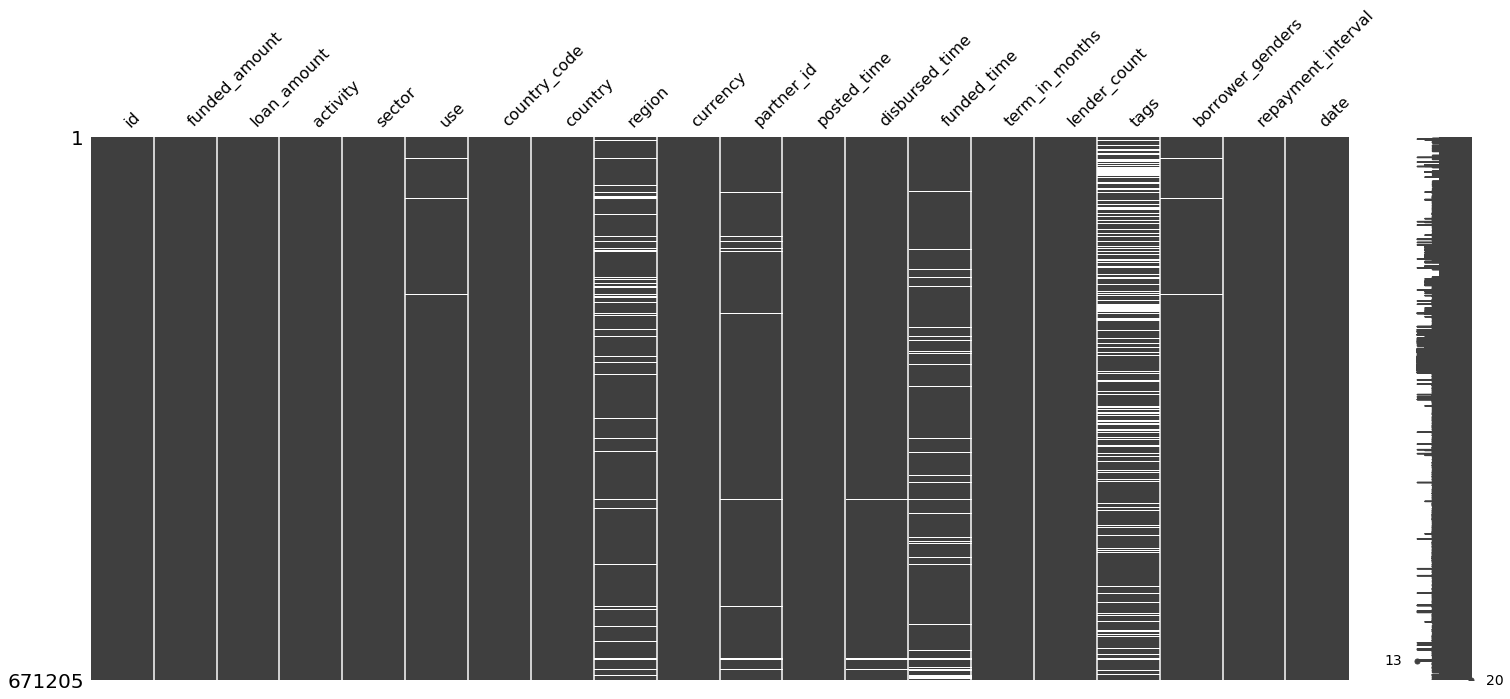

In [4]:
# Look at missing value
msno.matrix(kiva_full)

In [5]:
# Percentage of missing values in the entire dataset
missing_vals = kiva_full.isnull().sum()[kiva_full.isnull().sum() > 0]
total_cells = np.product(kiva_full.shape)
total_missing_vals = missing_vals.sum()
per_missing_vals = (total_missing_vals/total_cells) * 100
per_missing_vals

2.2415431947020656

Now let's work on the columns with missing values

In [6]:
# Lets check what are the countries for which country code is missing
kiva_full.loc[kiva_full.country_code.isnull(), 'country'].unique()

# Country code is missing for only Namibia - lets replace the missing values with NAM as country code
kiva_full['country_code'] = kiva_full['country_code'].fillna('NAM')

# disbursed_time , funded_time - substitute missing values with the corresponding value from posted_time
kiva_full['disbursed_time'] = kiva_full['disbursed_time'].fillna(kiva_full['posted_time'])
kiva_full['funded_time'] = kiva_full['funded_time'].fillna(kiva_full['posted_time'])

# borrower_genders - substitute missing values
kiva_full['borrower_genders'] = kiva_full['borrower_genders'].fillna(method='pad')

# log amount
kiva_full['log_amount'] = np.log(kiva_full['funded_amount'] + 1)

In [7]:
# Format date column to date format
kiva_full['disbursed_time'] = pd.to_datetime(kiva_full['disbursed_time'])
kiva_full['date'] = pd.to_datetime(kiva_full['date'])
kiva_full['posted_time'] = pd.to_datetime(kiva_full['posted_time'])
kiva_full['funded_time'] = pd.to_datetime(kiva_full['funded_time'])

In [8]:
# Add 2 columns containing count of males & females according to contents of the gender column
for i, row in kiva_full.iterrows():
    g = row['borrower_genders']         
    
    female = g.count('female')
    male = g.count('male')
    
    kiva_full.set_value(i, 'borrower_female', female)
    kiva_full.set_value(i, 'borrower_male', male)
    
kiva_full.borrower_male = kiva_full.borrower_male.astype(int)
kiva_full.borrower_female = kiva_full.borrower_female.astype(int)

View the Kiva loans dataset

In [9]:
kiva_full.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,log_amount,borrower_female,borrower_male
0,653051,300,300,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,...,2014-01-02 10:06:32,12,12,NaN,female,irregular,2014-01-01,5.707110,1,1
1,653053,575,575,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,...,2014-01-02 09:17:23,11,14,NaN,"female, female",irregular,2014-01-01,6.356108,2,2
2,653068,150,150,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,...,2014-01-01 16:01:36,43,6,"user_favorite, user_favorite",female,bullet,2014-01-01,5.017280,1,1
3,653063,200,200,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,...,2014-01-01 13:00:00,11,8,NaN,female,irregular,2014-01-01,5.303305,1,1
4,653084,400,400,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,...,2014-01-01 19:18:51,14,16,NaN,female,monthly,2014-01-01,5.993961,1,1


## A network of Partners, Themes & Regions


Kiva is able to reach more borrowers and some of the most remote places in the world through our global network of Field Partners. These partners are local organizations working in communities to vet borrowers, provide services and administer loans.

Our Field Partners are nonprofit organizations, microfinance institutions, schools, social enterprises and more. Many provide services with their loans, such as entrepreneurial training and literacy skills. <br>
Source: https://www.kiva.org/about/how


<br>

Let's take a look at how Partners are related to Regions & Loan Themes

In [11]:
kt2 = kiva_themes.groupby(['Field Partner Name', 'Loan Theme Type', 'region'])['number'].sum().reset_index().sort_values('number', ascending = False).reset_index(drop=True)

kt3=kt2[:300]
partners = kt3["Field Partner Name"].unique()
partners=partners.tolist()
themes = kt3["Loan Theme Type"].unique()
themes=themes.tolist()

In [12]:
G = nx.Graph()
G.add_nodes_from(kt3['Field Partner Name'], bipartite=0)
G.add_nodes_from(kt3['Loan Theme Type'], bipartite=1)
G.add_nodes_from(kt3['region'], bipartite=2)
G.add_weighted_edges_from(
    [(row['Field Partner Name'], row['Loan Theme Type'], row['number']) for idx, row in kt3.iterrows()], 
    weight='weight')
G.add_weighted_edges_from(
    [(row['Loan Theme Type'], row['region'], row['number']) for idx, row in kt3.iterrows()], 
    weight='weight')
G.add_weighted_edges_from(
    [(row['Field Partner Name'], row['region'], row['number']) for idx, row in kt3.iterrows()], 
    weight='weight')

pos=nx.random_layout(G)

dmin=1
ncenter=0
for n in pos:
    x,y=pos[n]
    d=(x-0.5)**2+(y-0.5)**2
    if d<dmin:
        ncenter=n
        dmin=d

p=nx.single_source_shortest_path_length(G,ncenter)

edge_trace = Scatter(
    x=[],
    y=[],
    line=Line(width=0.5,color='#888'),
    #line=Line(width=[],color='#888'),
    hoverinfo='text',
    text=[],
    mode='lines')

for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]
        
node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=False,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        #colorscale='RdBu',
        #reversescale=True,
        color=[],
        size=[],
        line=dict(width=2, color='black')
    )
    )

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'].append(x)
    node_trace['y'].append(y) 
 
    if (node in partners):
        col = "#2096BA"
        node_info = 'Partner: '+ str(node)
        s = 30
    elif (node in themes):
        col = "#842f82"
        node_info = 'Theme: '+ str(node)
        s = 36
    else:
        col = "#DF6E21"
        node_info = 'Region: '+ str(node)
        s = 24
    
    node_trace['text'].append(node_info)
    node_trace['marker']['color'].append(col) 
    node_trace['marker']['size'].append(s)
    
    

In [13]:
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='<br>Network of Partners, Themes & Regions (Blue = Partners, Purple = Themes, Orange = Regions)',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=XAxis(showgrid=True, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=True, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='networkx')

** Hover on the map to view the Partner, Theme & Region names

## Analysis of Kiva loan uses

The Kiva dataset lists various uses for which borrowers have taken up loans
Let's take a look at the frequency of some uses

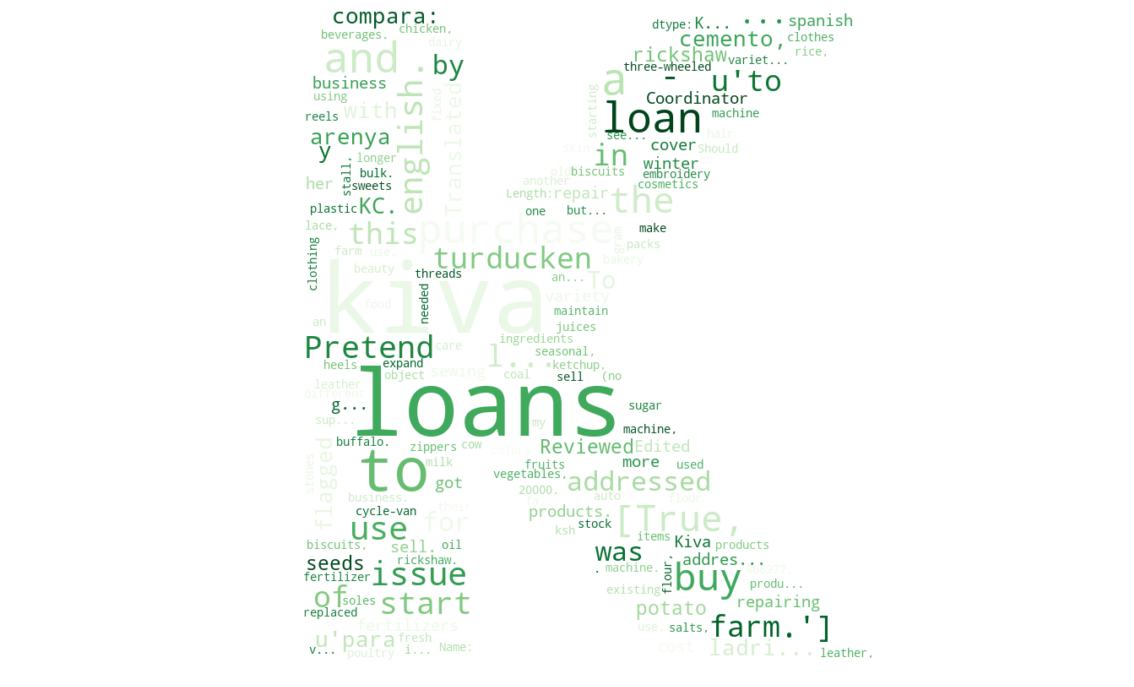

In [14]:
counts = dict()

words = str(kiva_loans['use'].dropna()).split()

for word in words:
    if word in counts:
        counts[word] += 1
    else:
        counts[word] = 1

counts = {k: v for k, v in counts.items() if not k.isdigit()}

counts['kiva'] = 120
counts['loans'] = 110

d = "data/"
mask = np.array(Image.open(path.join(d, "k6.jpg")))

stopwords=set(STOPWORDS)
stopwords.add('[True')
stopwords.add('''farm.]''')

wc = WordCloud(background_color="white", mask=mask, colormap="Greens",stopwords=stopwords)

# generate word cloud
wc.generate_from_frequencies(counts)

#image_colors = ImageColorGenerator(mask)

# show
fig,ax=plt.subplots(figsize=(25,12))
plt.imshow(wc,  interpolation='bilinear')
plt.axis("off")
plt.show()
# .recolor(color_func=image_colors)

In [15]:
# We will keep the above dataset for future reference & create another one for current (Country-wise) analysis
kiva_df = kiva_full.copy()
kiva_df = kiva_df.drop(labels=['id', 'use', 'tags', 'region', 'country_code', 'currency', 'partner_id', 'disbursed_time', 'funded_time', 'posted_time', 'borrower_genders', 'loan_amount'], axis=1)
kiva_df.columns = ['Amount', 'Activity', 'Sector', 'Country', 'Term', 'Lenders', 'Repayment_Interval', 'Date', 'Log_Amount', 'Females',  'Males']
kiva_df = kiva_df [['Country', 'Sector', 'Activity', 'Date', 'Repayment_Interval', 'Term', 'Amount', 'Log_Amount', 'Lenders', 'Females', 'Males']]

In [16]:
kiva_df.head()

,Country,Sector,Activity,Date,Repayment_Interval,Term,Amount,Log_Amount,Lenders,Females,Males
0,Pakistan,Food,Fruits & Vegetables,2014-01-01,irregular,12,300,5.707110,12,1,1
1,Pakistan,Transportation,Rickshaw,2014-01-01,irregular,11,575,6.356108,14,2,2
2,India,Transportation,Transportation,2014-01-01,bullet,43,150,5.017280,6,1,1
3,Pakistan,Arts,Embroidery,2014-01-01,irregular,11,200,5.303305,8,1,1
4,Pakistan,Food,Milk Sales,2014-01-01,monthly,14,400,5.993961,16,1,1


## Analyses of top factors from this dataset

We will use the above dataset to understand the top trends in Kiva loans in terms of the above datasets

### Top Countries

In [17]:
# Get a list of all Country names arranged by decreasing number of loans
countries = kiva_df['Country'].value_counts().to_frame()
countries.reset_index(inplace=True)
countries = countries.rename(columns = {'index':'Country', 'Country':'NumberOfLoans'})

# List of top 20 countries & their geographic coordinates
top20_list = countries[:20].copy()

top20_geo = top20_list.copy()
top20_geo = top20_geo.drop('NumberOfLoans', axis = 1)

In [18]:
for i, row in top20_geo.iterrows():
    try:
        geolocator = Nominatim()
        location = geolocator.geocode(row.Country)
        lat = location.latitude
        lon = location.longitude
        top20_geo.set_value(i, 'c_lat', lat)
        top20_geo.set_value(i, 'c_lon', lon)
    except AttributeError:
        pass

In [19]:
# Save to file so that geocode function doesnt have to be re run
top20_geo.to_csv("Top20_Countries_geo.csv", index=False)

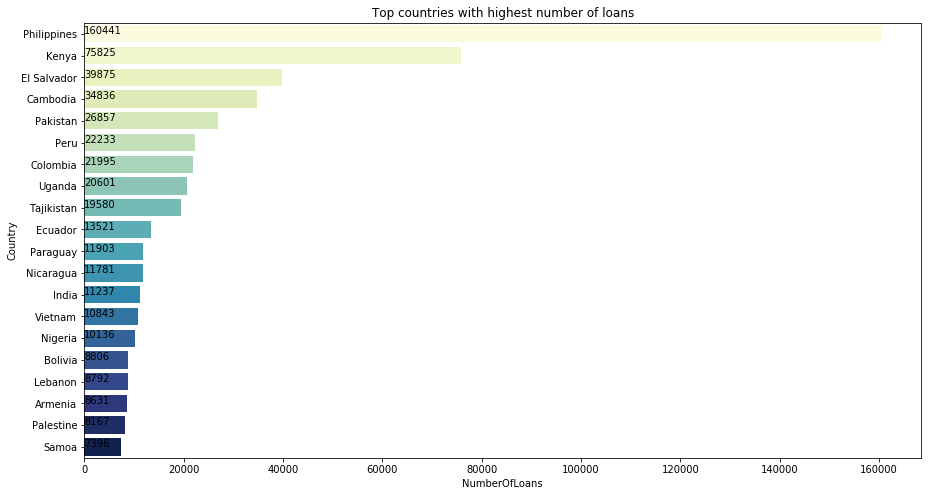

In [20]:
# Top countries with the hightest number of loans
colors = cm.YlGnBu(np.linspace(0,1,len(top20_list)))
fig, ax = plt.subplots(figsize=(15,8))
  
sns.barplot(top20_list.NumberOfLoans, top20_list.Country, ax = ax, palette=colors)
ax.set_title('Top countries with highest number of loans')

for i, v in enumerate(top20_list.NumberOfLoans):
    plt.text(0.8,i,v,color='k',fontsize=10)

plt.show()

### Top Sectors

Distribution of loans in various Sectors

In [164]:
cnt_s = kiva_df['Sector'].value_counts()

labels = cnt_s.index
values = cnt_s.values
trace = go.Pie(labels=labels, values=values)
py.iplot([trace], filename='basic_pie_chart')

The top sectors are:
- Agriculture
- Food
- Retail
- Services
- Personal Use

### Distribution of Loan amounts per Sector

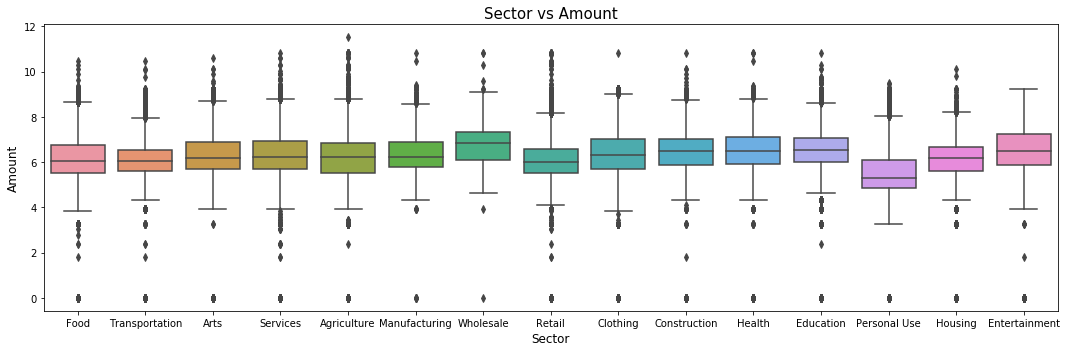

In [30]:
fig, ax = plt.subplots(figsize=(15,5))

sns.boxplot(x="Sector", y="Log_Amount", data=kiva_df, ax = ax)

ax.set_title("Sector vs Amount", fontsize=15)
ax.set_xlabel("Sector", fontsize=12)
ax.set_ylabel("Amount", fontsize=12)

plt.tight_layout()

### Top Activities

Distribution of loans per various Activities

In [31]:
cnt_a = kiva_df['Activity'].value_counts()

fig = {
  "data": [
    {
      "values": cnt_a.values,
      "labels": cnt_a.index,
      "text":"Activities",
      "textposition":"inside",
      "hoverinfo":"label+percent",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Activity Wise distributions",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Activities"
            }
        ]
    }
}
py.iplot(fig, filename='donut')

The top activities are:
- Farming
- General Store
- Personal Housing Expenses
- Food Production/Sales
- Agriculture

### Activity <-> Sector Mapping

Since each Sector can have multiple sub-Activities, let's take a look at a sample to see how they are connected

In [32]:
kt4=kiva_loans.groupby(['sector','activity'])['loan_amount'].sum().reset_index(name='amount').sort_values('amount', ascending = False).reset_index(drop=True)
kt4 = kt4.drop_duplicates()
kt4 = kt4.dropna()

kt4.loc[(kt4['activity'] == 'Retail'), 'activity'] = 'Activity_Retail'
kt4.loc[(kt4['activity'] == 'Agriculture'), 'activity'] = 'Activity_Agriculture'
kt4.loc[(kt4['activity'] == 'Clothing'), 'activity'] = 'Activity_Clothing'
kt4.loc[(kt4['activity'] == 'Food'), 'activity'] = 'Activity_Food'
kt4.loc[(kt4['activity'] == 'Health'), 'activity'] = 'Activity_Health'
kt4.loc[(kt4['activity'] == 'Services'), 'activity'] = 'Activity_Services'
kt4.loc[(kt4['activity'] == 'Manufacturing'), 'activity'] = 'Activity_Manufacturing'
kt4.loc[(kt4['activity'] == 'Transportation'), 'activity'] = 'Activity_Transportation'
kt4.loc[(kt4['activity'] == 'Arts'), 'activity'] = 'Activity_Arts'
kt4.loc[(kt4['activity'] == 'Construction'), 'activity'] = 'Activity_Construction'
kt4.loc[(kt4['activity'] == 'Wholesale'), 'activity'] = 'Activity_Wholesale'
kt4.loc[(kt4['activity'] == 'Entertainment'), 'activity'] = 'Activity_Entertainment'

sectors = kt4["sector"].unique()
sectors=sectors.tolist()

activities = kt4["activity"].unique()
activities=activities.tolist()

kt5 = kt4[:50]

In [33]:
G1 = nx.Graph()
G1.add_nodes_from(kt5['sector'], bipartite=0)
G1.add_nodes_from(kt5['activity'], bipartite=1)
G1.add_weighted_edges_from(
    [(row['sector'], row['activity'], row['amount']) for idx, row in kt5.iterrows()], 
    weight='weight')

pos1=nx.circular_layout(G1)

dmin1=1
ncenter1=0
for n in pos1:
    x,y=pos1[n]
    d=(x-0.5)**2+(y-0.5)**2
    if d<dmin1:
        ncenter1=n
        dmin1=d

p1=nx.single_source_shortest_path_length(G1,ncenter1)

edge_trace1 = Scatter(
    x=[],
    y=[],
    line=Line(width=1.5,color='#47112a'),
    #line=Line(width=[],color='#888'),
    hoverinfo='text',
    text=[],
    mode='lines')

for edge in G1.edges(data=True):
    for k,v in pos1.items():
        x0, y0 = pos1[edge[0]]
        x1, y1 = pos1[edge[1]]
        edge_trace1['x'] += [x0, x1, None]
        edge_trace1['y'] += [y0, y1, None]
        #edge_trace1['line']['color'].append()
        
node_trace1 = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=False,
        opacity= 0.9,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        #colorscale='RdBu',
        #reversescale=True,
        color=[],
        size=[],
        line=dict(width=2, color='#47112a')
    )
    )

for node in G1.nodes():
    x, y = pos1[node]
    node_trace1['x'].append(x)
    node_trace1['y'].append(y) 
 
    if (node in sectors):
        col = "#bf9a18"
        node_info = 'Sector: '+ str(node)
        s=50
    elif (node in activities):
        col = "#84174a"
        node_info = 'Activity: '+ str(node)
        s=50
    
    node_trace1['text'].append(node_info)
    node_trace1['marker']['color'].append(col) 
    node_trace1['marker']['size'].append(s)

In [34]:
fig1 = Figure(data=Data([edge_trace1, node_trace1]),
             layout=Layout(
                title='<br>Top Sectors <-> Activity contributors (Blue = Sector, Yellow = Activity)',
                titlefont=dict(size=20),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=XAxis(showgrid=True, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=True, zeroline=False, showticklabels=False)))

py.iplot(fig1, filename='networkx1')

** Hover on the map to view the Activity & Sector names

### Top 3 Activities in Top 5 sectors

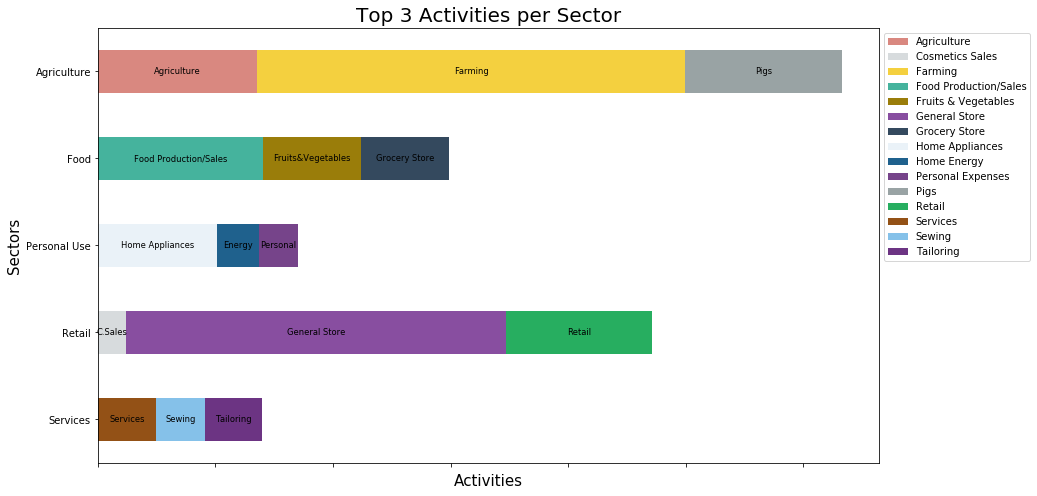

In [35]:
cnt_s5 = cnt_s[:5]
sectors = ['Agriculture', 'Food', 'Retail', 'Services', 'Personal Use']
cnt_a2 = kiva_df.groupby(['Sector'])['Activity'].value_counts().groupby(level=0).head(3).reset_index(name='count')
cnt_a2 = cnt_a2.groupby(['Sector','Activity'], as_index=False)['count'].sum()
cnt_a2 = pd.DataFrame(cnt_a2)
cnt_a2 = cnt_a2.loc[cnt_a2['Sector'].isin(sectors)].reset_index(drop=True)

color_list = ['#D98880', '#D7DBDD', '#F4D03F', '#45B39D', '#9A7D0A', '#884EA0', '#34495E', '#EAF2F8', '#1F618D', '#76448A', '#99A3A4', '#27AE60', '#935116', '#85C1E9', '#6C3483']
fig, ax = plt.subplots(figsize=(14,8))
cnt_p = cnt_a2.pivot_table(index="Activity", columns="Sector", values="count").T.fillna(0)
cnt_p.plot(kind='barh', ax=ax, color=color_list, stacked=True, legend=True).invert_yaxis()

ax.set_title("Top 3 Activities per Sector", fontsize=20)
ax.set_xlabel("Activities", fontsize=15)
ax.set_ylabel("Sectors", fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


labels = []
for j in cnt_p.columns:
    for i in cnt_p.index:
        label = str(j)
        if (label=="Fruits & Vegetables"):
            label = "Fruits&Vegetables"
        if (label=="Home Energy"):
            label = "Energy"
        if (label=="Personal Expenses"):
            label = "Personal"
        if (label=="Cosmetics Sales"):
            label = "C.Sales"
        labels.append(label)

                
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center', fontsize="small")
plt.legend(bbox_to_anchor=(1.2,1), fontsize=10)


From the above, the Top 3 Activities per Sector are:
- Sector - "Agriculture" ::: Activities - "Agriculture", "Farming", "Pigs"
- Sector - "Food" ::: Activities - "Food Production/Sales", "Fruits & Vegetables", "Grocery Store"
- Sector - "Personal Use" ::: Activities - "Home Appliances", "Energy", "Personal Expenses"
- Sector - "Retail" ::: Activities - "Cosmetic Sales", "General Store", "Retail"
- Sector - "Services" ::: Activities - "Services", "Sewing", "Tailoring"



## Time-Based Analysis

### Increase in Number of Loans Over time

In [36]:
kiva_time = kiva_df.copy()
kiva_time['Year'] = kiva_time['Date'].dt.year
kiva_time = kiva_time[kiva_time.Year != 2017]

kiva_growth = pd.DataFrame(kiva_time.groupby('Country').size()).reset_index().rename(columns={'Country': 'Country', 0: 'Count'}).sort_values(by = 'Count', ascending = False).reset_index(drop=True)
kiva_temp = pd.DataFrame(kiva_time.groupby(['Country', 'Year']).size()).reset_index().rename(columns={'Country': 'Country', 0: 'Count'}).sort_values(by = 'Count', ascending = False).reset_index(drop=True)

for i, row in kiva_growth.iterrows():
    Counts_2014 = kiva_temp.loc[(kiva_temp.Country==row.Country) & (kiva_temp.Year == 2014)].Count
    Counts_2015 = kiva_temp.loc[(kiva_temp.Country==row.Country) & (kiva_temp.Year == 2015)].Count
    Counts_2016 = kiva_temp.loc[(kiva_temp.Country==row.Country) & (kiva_temp.Year == 2016)].Count
    Counts_2017 = kiva_temp.loc[(kiva_temp.Country==row.Country) & (kiva_temp.Year == 2017)].Count
    
    if (len(Counts_2014) == 0):
        kiva_growth.set_value(i, 'Counts_2014', 0)
    else:
        kiva_growth.set_value(i, 'Counts_2014', Counts_2014.item())
        
    if (len(Counts_2015) == 0):
        kiva_growth.set_value(i, 'Counts_2015', 0)
    else:
        kiva_growth.set_value(i, 'Counts_2015', Counts_2015.item())
        
    if (len(Counts_2016) == 0):
        kiva_growth.set_value(i, 'Counts_2016', 0)
    else:
        kiva_growth.set_value(i, 'Counts_2016', Counts_2016.item())
        
    if (len(Counts_2017) == 0):
        kiva_growth.set_value(i, 'Counts_2017', 0)
    else:
        kiva_growth.set_value(i, 'Counts_2017', Counts_2017.item())        

        
increase = kiva_growth.loc[kiva_growth.Counts_2016 > kiva_growth.Counts_2014].Country.value_counts().sum()
decrease = kiva_growth.loc[kiva_growth.Counts_2016 < kiva_growth.Counts_2014].Country.value_counts().sum()
same = kiva_growth.loc[kiva_growth.Counts_2016 == kiva_growth.Counts_2014].Country.value_counts().sum()
total = kiva_growth.Country.value_counts().sum()
inc_per = increase/total * 100
dec_per = decrease/total * 100

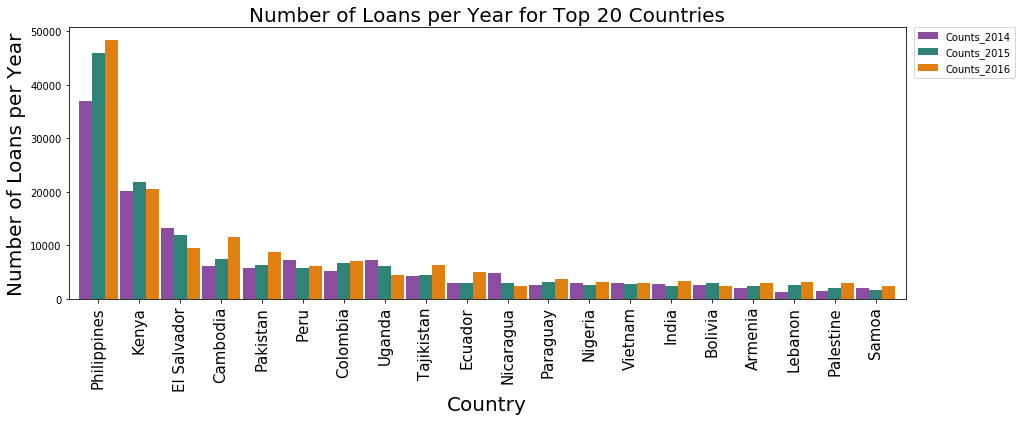

In [37]:
color_list = ['#8a4da0', '#2f8477', '#e08011']
fig, ax = plt.subplots(figsize=(15,5))
kg = kiva_growth[:20]

kg.plot(x="Country", y=["Counts_2014", "Counts_2015", "Counts_2016"], 
        kind="bar", ax = ax, width=0.95, color=color_list)
ax.set_title("Number of Loans per Year for Top 20 Countries", fontsize=20)
ax.set_xlabel("Country", fontsize=20)
ax.set_ylabel("Number of Loans per Year", fontsize=20)
ax.set_xticklabels(labels = ax.get_xticklabels(), fontsize=15)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

Out of a Total of 85 Kiva countries, 
- for 46 countries (54% of countries) Number of Loans has increased from 2014 to 2016
- for 38 countries (46% of countries) Number of Loans has decreased from 2014 to 2016

### Changes in Popularity of Repayment Intervals over the years

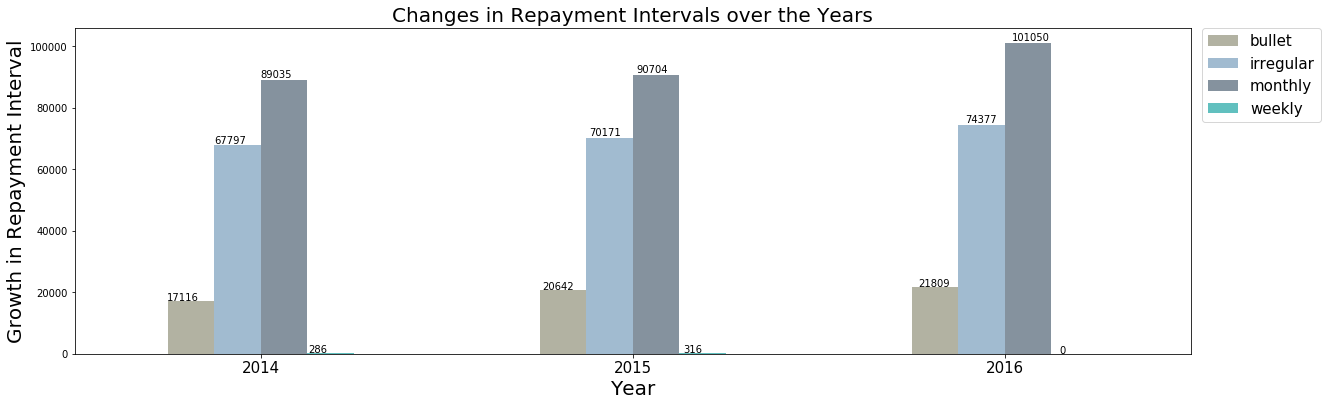

In [38]:
color_list = ['#b2b2a2' , '#A1BBD0', '#85929E' , '#61C0BF' ]

fig, ax = plt.subplots(figsize=(20,6))
#ax.set_facecolor('#E5DACE')
kiva_time.groupby(['Repayment_Interval', 'Year']).size().reset_index().rename(columns={0: 'Count'}).pivot_table(index="Repayment_Interval", columns="Year", values="Count").T.plot(kind='bar', ax=ax, color=color_list)
ax.set_title("Changes in Repayment Intervals over the Years", fontsize=20)
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel("Growth in Repayment Interval", fontsize=20)
ax.set_xticklabels(labels = ax.get_xticklabels(), fontsize=15, rotation=0)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=15)
#ax.grid(True)
for p in ax.patches:
    ax.annotate((p.get_height()).astype(int), (p.get_x() * 1.01, p.get_height() * 1.01))
    
plt.show()

- There has been increase in all the Repayment Intervals over time, except for Weekly
- Popularity for Bullet intervals  has increased by 27% between 2014 to 2016
- Popularity for Irregular intervals has increased by 9.7% between 2014 & 2016
- Popularity for Monthly intervals has increased by 13.5% between 2014 & 2016
    
So, Bullet seems to be the interval growing most in popularity over the years
& Weekly is the interval decreasing most in popularity over time

### Distribution of Funded & Loan Amounts over Time

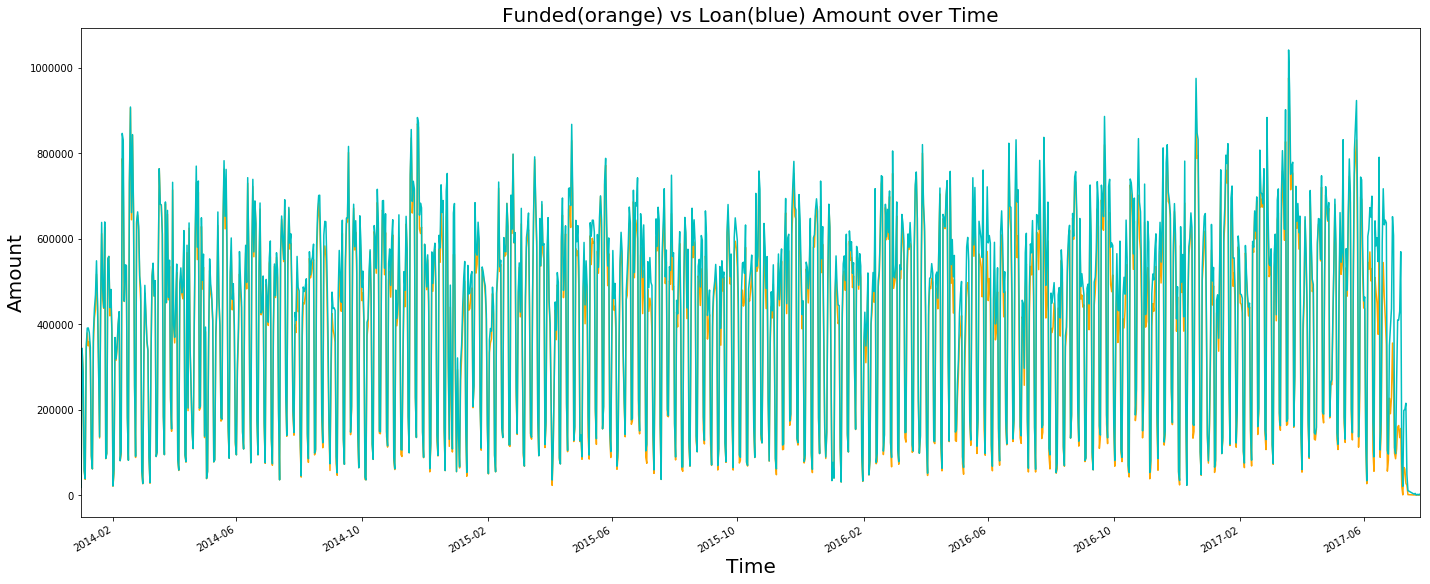

In [39]:
fig, ax = plt.subplots(figsize=(24,10))
kiva_full.groupby(['date'])['funded_amount'].sum().reset_index().sort_values(by = 'date', ascending = True).plot(x="date", ax=ax, c='orange')
kiva_full.groupby(['date'])['loan_amount'].sum().reset_index().sort_values(by = 'date', ascending = True).plot(x="date", ax=ax, c='c')
ax.set_title("Funded(orange) vs Loan(blue) Amount over Time", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Amount", fontsize=20)
ax.legend_.remove()
plt.show()

- The above chart shows the distribution of Funded Amount(orange line) vs Loan Amount(Blue line) over time
- There is a high correlation between Funded Amount & Loan Amount
- For the majority, Funded Amount = Loan Amount
- There are few instances for which, Funded Amount < Loan Amount
- However, we do not see any instances for which, Funded Amount > Loan Amount
- As conclusion we could say that the amount that gets actually funded (amount funded from lenders) is equal to or less than the loan amount  (amount requested by the borrower) for each loan

## Data Analysis of Top 20 countries

In [79]:
top20_data = pd.read_csv("Top20_Countries_geo.csv")
top20_data = top20_data.merge(metrics, how="left", on = "Country")
top20_data = top20_data.merge(kiva_df.groupby(['Country'],as_index=False).Amount.sum())
top20_data = top20_data.merge(kiva_df.groupby(['Country'],as_index=False).Lenders.sum())
top20_data = top20_data.merge(kiva_df.groupby(['Country'],as_index=False).Females.sum())
top20_data = top20_data.merge(kiva_df.groupby(['Country'],as_index=False).Males.sum())
top20_data = top20_data.merge(kiva_df.groupby('Country',as_index=False).Sector.first())
top20_data = top20_data.merge(kiva_df.groupby('Country',as_index=False).Activity.first())
top20_data = top20_data.merge(kiva_df.groupby('Country',as_index=False).Repayment_Interval.first())
top20_data = top20_data.merge(kiva_df.groupby('Country',as_index=False).Term.first())
top20_data = top20_data.drop(labels=['GDP_Total', 'GDP_per_Capita', 'HDI_Value'], axis=1)

In [80]:
m = folium.Map(location=[0,0], tiles="Mapbox Control Room",  zoom_start=2)

for i in range(0,len(top20_data)):
    sr = round(top20_data.iloc[i]["Males"]/top20_data.iloc[i]["Females"], 2)
    popup_text = "Country: {}<br> Rank: {}<br> Loans: {}<br> Sector: {}<br> Sex Ratio: {}<br> Total Amount: {}<br> Repayment Interval: {}<br> HDI Scale: {}<br> Income Category: {} "
    popup_text = popup_text.format(top20_data.iloc[i]["Country"],
                                   i+1,
                                   top20_data.iloc[i]["NumberOfLoans"],
                                   top20_data.iloc[i]["Sector"],
                                   sr,
                                   top20_data.iloc[i]['Amount'],                                  
                                  top20_data.iloc[i]['Repayment_Interval'],
                                  top20_data.iloc[i]['HDI_Scale'],
                                  top20_data.iloc[i]['Category'])
    
    
    folium.Marker([top20_data.iloc[i]['c_lat'],
                   top20_data.iloc[i]['c_lon']],
                  popup=popup_text,
                 icon = folium.Icon(color='darkgreen', icon='address-card')).add_to(m)
    
display(m)

### The pop ups displayed on clicking the markers in the above map, provides a comprehensive view of the Top 20 Countries:
- Country Name
- Rank in terms of Number of Loans
- Number of Loans
- Top Sector
- Sex Ratio
- Total Loan Amount
- Most popular Repayment Interval
- HDI Scale
- Income Category

## Metrics

In this section we will take a look at how external measures of economic welfare affect Kiva loans 
<br>
There are various measures that can used to understand the economic welfare of countries/regions throughout the world - Such data is published & made available publicly by various organizations, such as The World Bank, United Nations Human Development Reports, Organisation for Economic Co-operation and Development (OECD), to name a few


Here we will collate the data from various sources to understand different factors & how these factors affects Kiva borrower situations. In most cases, we will take into consideration the latest available data (2016 in majority cases, & in case data for 2016 is not available in the particular dataset, we consider the data from the last year that is available)


In the first section we will look at which type of economic conditions account for the maximum of Kiva loans
<br>
In the next section we will look at how various factors attribute to Poverty in different regions


There can be various aspects that can be considered while trying to interpret progress at a national or sub-national level:


• Economic growth

• Economic welfare

• Human Development

• Sustainable development

• Human welfare

• Well-being

Over the years, local conditions for different aspects have been measured to understand the economic/overall progress of a country
<br>
Here, we will look at some of these measures, what they mean, how they span across regions & how they affect Kiva borrowing conditions

### Economic Growth & Welfare

<b> Gross domestic product (GDP) </b> 
<br>
GDP is a monetary measure of the market value of all final goods and services produced in a period (quarterly or yearly) of time.
This has been one of the most widely used measures of Economic Growth thoughout the world over time
<br>
GDP is mostly used to understand Economic Growth, with reference to increasing output by an economy as measured production
However, there have been many criticism of GDP, implying that it focuses on what are considered wrongful inclusions and exclusions, & does not include certain other relevant factors


<b> Gross Domestic Product Per Capita (GDP per Capita) </b>
<br>
GDP per Capita is used as a measure of economic welfare, rather than economic growth - It is employed to focus on the impact of economic growth on the material living standards of households and individual citizens, rather than on production. It includes in-kind services provided by government such as subsidized health care and educational services, while excluding defense spending and general government expenses which do not directly contribute to household consumption. It also emphasizes the importance of the distribution of income and wealth in society. 
<br>
It is commonly measured in terms of per capita GDP or per capita household consumption expenditure at constant currency value. 


<b> Gross National Income Product Per Capita (GNI per Capita) </b>
<br>
Gross national income is a measurement of a country's income. It includes all the income earned by a country's residents and businesses, including those earned abroad. Income is defined as all employee compensation and investment income. This includes even those from foreign sources. Product taxes (minus subsidies) not already counted also fall under the GNI. It does not count income earned by foreigners located in the country though.
<br>


<b> Classification of Income Categories</b>
<br>
Economies are currently divided into four income groupings: low, lower-middle, upper-middle, and high, based on GNI per capita (in U.S. dollars, converted from local currency using the Atlas method)
<br>
This measure is used in order to classify the countries of the world into various income levels
The income groupings use GNI per capita (in U.S. dollars, converted from local currency using the Atlas method) since they follow the same methodology used by the World Bank when determining it’s operational lending policy. While it is understood that GNI per capita does not completely summarize a country’s level of development or measure welfare, it has proved to be a useful and easily available indicator that is closely correlated with other, nonmonetary measures of the quality of life, such as life expectancy at birth, mortality rates of children, and enrollment rates in school.

In [104]:
# The data for GDP, GDP per Capita & GNI per Capita is taken from UNHD Reports
gdp = pd.read_excel('data/Self data/GDP_GNI.xlsx', 'Data', index_col=None)

# The data for Income Group classifications is taken from The World Bank's dataset
inc = pd.read_excel('data/Self data/Income_classification.xls', 'Data', index_col=None)

# Gowth in GDP (percent increase) - World Bank data
pgdp = pd.read_excel('data/Self data/GDP_growth.xls', 'Data', index_col=None)

### Human Development

<b> Human Development Index</b>
<br>
Human Development Index (HDI) is a composite statistic (composite index) of life expectancy, education, and per capita income indicators, which are used to rank countries into four tiers of human development. A country scores higher HDI when the lifespan is higher, the education level is higher, and the GDP per capita is higher. 


<b> Inequality-adjustedHuman Development Index</b>
<br>
The IHDI can be interpreted as the level of human development when inequality is accounted for

In [106]:
# The data for HDI is taken from UNHD Reports
hdi = pd.read_excel('data/Self data/HDI_IHDI.xlsx', 'Data', index_col=None)

Let's take a look at the distribution of countries according to their Human Development Index values

In [107]:
data = [ dict(
        type = 'choropleth',
        locations = hdi['Country'],
        locationmode='country names',
        z = hdi['HDI_Value'],
        text = hdi['HDI_Value'],
        colorscale = [[0,"rgb(1, 73, 99)"],[0.35,"rgb(42, 126, 168)"],[0.5,"rgb(102, 177, 214)"],\
            [0.6,"rgb(131, 219, 226)"],[0.7,"rgb(222, 247, 249)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,        
        hoverinfo="location+text",
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
       showscale=False,
      ) ]

layout = dict(
    title = 'Human Development Index',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout)
py.iplot( fig, validate=False)

In this section we will try to understand how economic measures impact Kiva borrowing patterns - Mainly tring to understand which type of economied account for a majority of Kiva loans
To start with, let's take a look at distribution of Kiva loans over the world

In [108]:
d1 = hdi.merge(countries, how="left", on="Country")
d1['NumberOfLoans']=d1['NumberOfLoans'].fillna(0)

data = [ dict(
        type = 'choropleth',
        locations = d1['Country'],
        locationmode='country names',
        z = np.log(d1['NumberOfLoans'] + 1),
        text = d1['NumberOfLoans'],
        colorscale = [[0,"rgb(122, 3, 21)"],[0.1,"rgb(155, 3, 41)"],[0.2,"rgb(183, 14, 73)"],\
            [0.3,"rgb(219, 41, 124)"],[0.4,"rgb(219, 41, 166)"],[0.5,"rgb(214, 64, 204)"],\
            [0.6,"rgb(212, 79, 221))"],[0.7,"rgb(224, 106, 242)"],[0.8,"rgb(220, 125, 242)"],\
                      [0.9,"rgb(213, 184, 242)"],[1.0,"rgb(249, 222, 249)"]
                     ],
        autocolorscale = False,
        reversescale = True,
        hoverinfo="location+text",
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        showscale=False,
      ) ]

layout = dict(
    title = 'Number of Loans',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout)
py.iplot( fig, validate=False)

In [114]:
df = kiva_full.merge(metrics, how="left", left_on = "country", right_on="Country")

df.loc[((df.HDI_Scale == "Very High") & (df.IncomeCategory == "High income")), 'Group'] = 'G8'
df.loc[((df.HDI_Scale == "High") & (df.IncomeCategory == "Upper middle income")), 'Group'] = 'G7'
df.loc[((df.HDI_Scale == "High") & (df.IncomeCategory == "Lower middle income")), 'Group'] = 'G6'
df.loc[((df.HDI_Scale == "Medium") & (df.IncomeCategory == "Upper middle income")), 'Group'] = 'G5'
df.loc[((df.HDI_Scale == "Medium") & (df.IncomeCategory == "Lower middle income")), 'Group'] = 'G4'
df.loc[((df.HDI_Scale == "Medium") & (df.IncomeCategory == "Low income")), 'Group'] = 'G3'
df.loc[((df.HDI_Scale == "Low") & (df.IncomeCategory == "Lower middle income")), 'Group'] = 'G2'
df.loc[((df.HDI_Scale == "Low") & (df.IncomeCategory == "Low income")), 'Group'] = 'G1'

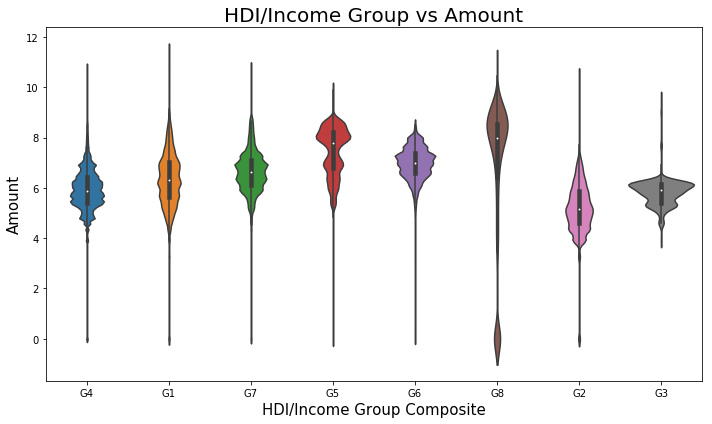

In [115]:
# Plot of Income Groups vs Loan Amount
fig, ax = plt.subplots(figsize=(10,6))

sns.violinplot("Group","log_amount",data=df, ax = ax)

ax.set_title("HDI/Income Group vs Amount", fontsize=20)
ax.set_xlabel("HDI/Income Group Composite", fontsize=15)
ax.set_ylabel("Amount", fontsize=15)

plt.tight_layout()

- <b> G1: </b> Low Income Category, Low Human Development
- <b> G2: </b> Lower middle Income Category, Low Human Development
- <b> G3: </b> Low Income Category, Medium Human Development
- <b> G4: </b> Lower middle Income Category, Medium Human Development
- <b> G5: </b> Upper middle Income Category, Medium Human Development
- <b> G6: </b> Lower middle Income Category, High Human Development
- <b> G7: </b> Upper middle Income Category, High Human Development
- <b> G8: </b> High Income Category, Very High Human Development


In [118]:
df_m1 = df_m[['HDI_Scale', 'IncomeCategory']].drop_duplicates().merge(df.groupby(['HDI_Scale', 'IncomeCategory'],as_index=False).sector.first())
df_m1 = df_m1.merge(df.groupby(['HDI_Scale', 'IncomeCategory'],as_index=False).activity.first())
df_m1 = df_m1.merge(df.groupby(['HDI_Scale', 'IncomeCategory'],as_index=False).repayment_interval.first())
df_m1 = df_m1.merge(df_m.groupby(['HDI_Scale', 'IncomeCategory'],as_index=False).BankRate.first())
df_m1 = df_m1.merge(df_m.groupby(['HDI_Scale', 'IncomeCategory'],as_index=False).GDP_growth.first())
df_m1 = df_m1.merge(df_m.groupby(['HDI_Scale', 'IncomeCategory'],as_index=False).NumberOfLoans.sum())
df_m1 = df_m1.merge(df_m.groupby(['HDI_Scale', 'IncomeCategory'],as_index=False).PercentLoans.sum())
df_m1 = df_m1.merge(df.groupby(['HDI_Scale', 'IncomeCategory'],as_index=False).borrower_female.sum())
df_m1 = df_m1.merge(df.groupby(['HDI_Scale', 'IncomeCategory'],as_index=False).borrower_male.sum())
df_m1 = df_m1.merge(df.groupby(['HDI_Scale', 'IncomeCategory'],as_index=False).loan_amount.sum())

df_m1.style.background_gradient(cmap="Set3_r")

,HDI_Scale,IncomeCategory,sector,activity,repayment_interval,BankRate,GDP_growth,NumberOfLoans,PercentLoans,borrower_female,borrower_male,loan_amount
0,Medium,Lower middle income,Food,Fruits & Vegetables,irregular,Medium,High,329699,64.3198,553090,676543,248389750
1,High,Upper middle income,Personal Use,Personal Expenses,monthly,High,Moderate,73232,14.2866,109728,150597,101441700
2,Low,Low income,Food,Butcher Shop,monthly,Very High,High,62834,12.2581,207161,270946,79276675
3,High,Lower middle income,Services,Tailoring,monthly,High,Moderate,17134,3.34261,10715,17214,24457250
4,Medium,Upper middle income,Retail,Retail,monthly,High,High,12289,2.39742,117958,121244,32864525
5,Low,Lower middle income,Services,Barber Shop,monthly,High,Low,11112,2.1678,6450,16963,4028975
6,Very High,High income,Food,Food Production/Sales,monthly,Low,Moderate,6293,1.22768,3884,6568,32338475


- A total of <b>  329699 </b> Kiva borrowers are from the <b> Medium HDI & Lower Middle Income brackets </b>
- So, this bracket accounts for almost <b> 64 % Kiva borrowers </b>


From this analysis, we can see that a majority of Kiva borrowers are from countries that are on a moderate scale in terms of Income & Economic Development & Welfare, and that there isn't a direct correlation between low levels of economic/human development with the amount of loans being taken


<b>Effects of a growing economy(GDP% Growth)</b>
<br>
In that case, what could be the factors that result in more number of borrowers
As we can see, majority of Kiva loans are taken by countries that are moderately Developed. This suggests that a <b>Growing economy</b>, resulting in more demand in resources for the people, might be the cause for a higher number of loans. Let's take a look at how <b> Growth in GDP </b> accounts for Kiva loans


<b>Effects of a local Baking</b>
<br>
From another perspective, since Kiva is a loan-providing organization, the traditional mode for people to avail loans would be local banks. So now the question would arise as to why someone would take a loan from Kiva & not from their local banks. This could be because local banks might have a high rate of interest


In order to analyze these factors, we will take a look at the distribution of Kiva loans according to local GDP Growth & Bank Lending Interest Rates

In [109]:
# Bank Lending Rates (Source: The World Bank)
lend = pd.read_csv('data/Self data/Bank Lending Rates.csv', 'Data', index_col=None, engine='python', delimiter=",")

In [110]:
metrics = countries.merge(gdp, how="left", on = "Country")
metrics = metrics.merge(hdi, how="left", on = "Country")
metrics = metrics.merge(inc, how="left", on = "Country")
metrics = metrics.merge(lend, how="left", on = "Country")
metrics = metrics.merge(pgdp, how="left", on = "Country")

# We will group the rates of growth in categories
bins = [-7,0,3,7,11]
group_names = ['Low','Moderate','High','Very High']
metrics["GDP_growth"] = pd.cut(metrics["GDP_growthPercent"], bins, labels=group_names)

# We will group the Bank Lending rates in categories
bins1 = [2,5,8,20,53]
group_names1 = ['Low','Medium','High','Very High']
metrics["BankRate"] = pd.cut(metrics["Bank Rate"], bins1, labels=group_names1)

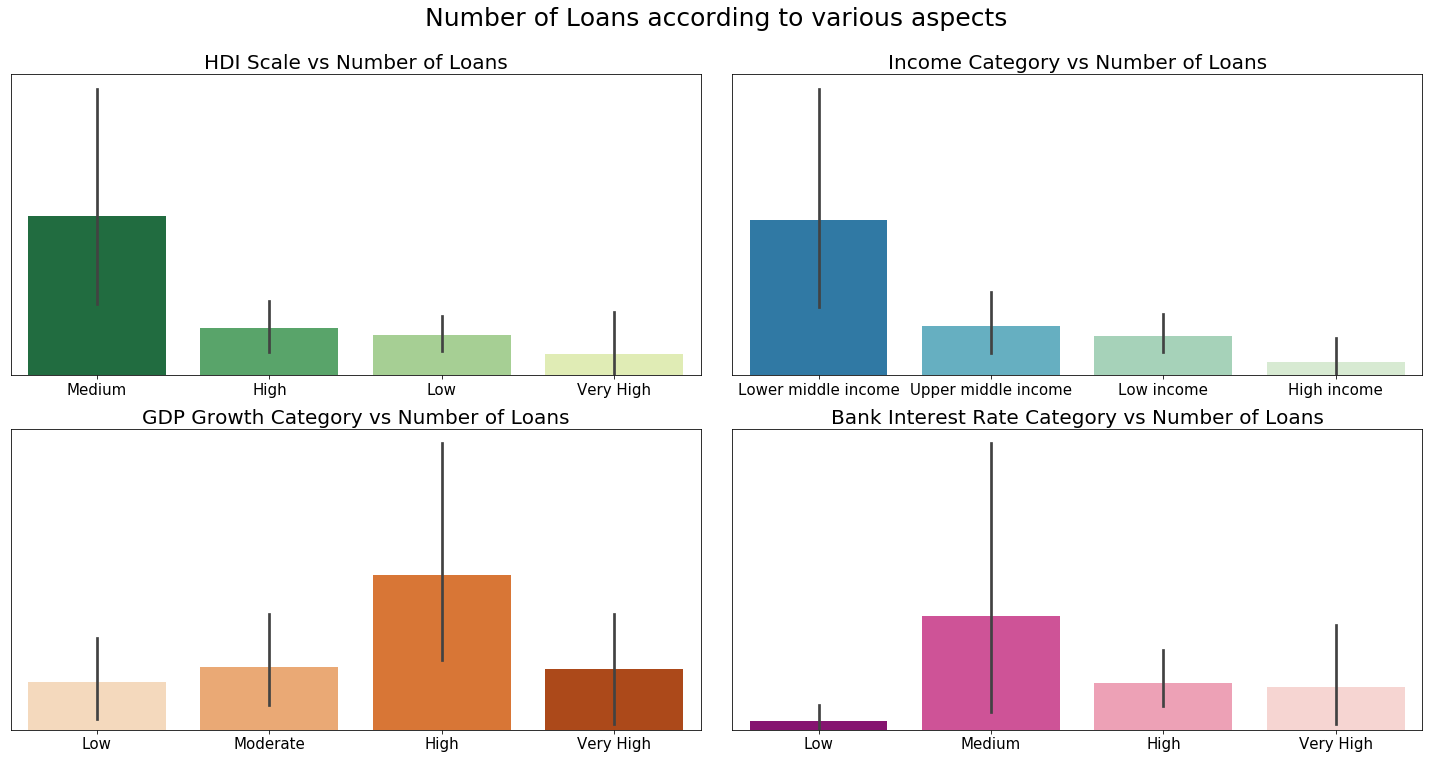

In [111]:
fig, ax = plt.subplots(2,2,figsize=(20, 10))

a = sns.barplot(x="HDI_Scale", y="NumberOfLoans", data=metrics, palette="YlGn_r", ax=ax[0][0])
b = sns.barplot(x="IncomeCategory", y="NumberOfLoans", data=metrics, palette="GnBu_r", ax = ax[0][1])
c = sns.barplot(x="GDP_growth", y="NumberOfLoans", data=metrics, palette="Oranges", ax = ax[1][0])
d = sns.barplot(x="BankRate", y="NumberOfLoans", data=metrics, palette="RdPu_r", ax = ax[1][1])

ax[0][0].set_title('HDI Scale vs Number of Loans', fontsize=20)
ax[0][0].get_yaxis().set_visible(False)
ax[0][0].get_xaxis().get_label().set_visible(False)
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), fontsize=15)

ax[0][1].set_title('Income Category vs Number of Loans', fontsize=20)
ax[0][1].get_yaxis().set_visible(False)
ax[0][1].get_xaxis().get_label().set_visible(False)
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), fontsize=15)

ax[1][0].set_title('GDP Growth Category vs Number of Loans', fontsize=20)
ax[1][0].get_yaxis().set_visible(False)
ax[1][0].get_xaxis().get_label().set_visible(False)
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), fontsize=15)

ax[1][1].set_title('Bank Interest Rate Category vs Number of Loans', fontsize=20)
ax[1][1].get_yaxis().set_visible(False)
ax[1][1].get_xaxis().get_label().set_visible(False)
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), fontsize=15)

plt.suptitle('Number of Loans according to various aspects', fontsize=25, y=1.05)
plt.tight_layout()
plt.show()

In [112]:
df_m = metrics.groupby(['HDI_Scale', 'IncomeCategory', 'GDP_growth', 'BankRate'])['NumberOfLoans'].sum().reset_index(name='NumberOfLoans').sort_values('NumberOfLoans', ascending = False).reset_index(drop=True)
tot = df_m["NumberOfLoans"].sum()
df_m["PercentLoans"] = df_m["NumberOfLoans"]/tot * 100

df_m.style.background_gradient(cmap="Pastel1_r")

,HDI_Scale,IncomeCategory,GDP_growth,BankRate,NumberOfLoans,PercentLoans
0,Medium,Lower middle income,High,Medium,180090,35.1331
1,Medium,Lower middle income,High,High,138366,26.9933
2,High,Upper middle income,Moderate,High,30787,6.00613
3,High,Upper middle income,High,High,26224,5.11595
4,Low,Low income,High,Very High,24084,4.69846
5,Low,Low income,High,Medium,18614,3.63134
6,High,Lower middle income,Moderate,High,17134,3.34261
7,Medium,Upper middle income,High,High,11903,2.32212
8,Medium,Lower middle income,Very High,High,11239,2.19258
9,Low,Low income,High,High,10634,2.07455


In [113]:
mid_loans = metrics[(metrics["HDI_Scale"]=='Medium') & (metrics["IncomeCategory"]=='Lower middle income')].NumberOfLoans.sum()
high_loans = metrics[(metrics["GDP_growth"]=='High')].NumberOfLoans.sum()
br_loans = metrics[(metrics["BankRate"]=='High')].NumberOfLoans.sum()
mix_loans = metrics[(metrics["HDI_Scale"]=='Medium') & (metrics["IncomeCategory"]=='Lower middle income') & (metrics["GDP_growth"]=='High')].NumberOfLoans.sum()
total_loans = metrics['NumberOfLoans'].sum()
per_mid_loans = (mid_loans/total_loans) * 100
per_br_loans = (br_loans/total_loans) * 100
per_high_loans = (high_loans/total_loans) * 100
per_mix_loans = (mix_loans/total_loans) * 100

- <b> 72%  </b> of Kiva borrowers are from the countries that have a <b> High GDP Growth </b>
<br>
- <b> 41%  </b> of Kiva borrowers are from the countries that have a <b> High Bank Lending Rate </b>
<br>
- <b> 56%  </b> of Kiva borrowers are from the countries that are from the <b> Medium HDI , Lower Middle Income & High GDP Growth brackets </b>



## Top Loan uses per Income/Development Category

Earlier we had a look at the overall uses for Kiva loans
<br>
Now, let's try to see if the uses for Kiva loans are affected by the type of Kiva borrowers defined by their Income/Development Groups

In [119]:
v1 = TfidfVectorizer(stop_words='english', max_df=0.1)
x1 = v1.fit_transform(df[(df.HDI_Scale=='Low') & (df.IncomeCategory=='Low income')].use.dropna())
weights1 = np.asarray(x1.mean(axis=0)).ravel().tolist()
weights_df1 = pd.DataFrame({'term': v1.get_feature_names(), 'weight': weights1})

v2 = TfidfVectorizer(stop_words='english', max_df=0.1)
x2 = v2.fit_transform(df[(df.HDI_Scale=='Medium') & (df.IncomeCategory=='Lower middle income')].use.dropna())
weights2 = np.asarray(x2.mean(axis=0)).ravel().tolist()
weights_df2 = pd.DataFrame({'term': v2.get_feature_names(), 'weight': weights2})

v3 = TfidfVectorizer(stop_words='english', max_df=0.1)
x3 = v3.fit_transform(df[(df.HDI_Scale=='High') & (df.IncomeCategory=='Upper middle income')].use.dropna())
weights3 = np.asarray(x3.mean(axis=0)).ravel().tolist()
weights_df3 = pd.DataFrame({'term': v3.get_feature_names(), 'weight': weights3})

v4 = TfidfVectorizer(stop_words='english', max_df=0.1)
x4 = v4.fit_transform(df[(df.HDI_Scale=='Very High') & (df.IncomeCategory=='High income')].use.dropna())
weights4 = np.asarray(x4.mean(axis=0)).ravel().tolist()
weights_df4 = pd.DataFrame({'term': v4.get_feature_names(), 'weight': weights4})


w1 = weights_df1.sort_values(by='weight', ascending=False)[:10].reset_index(drop=True)
w2 = weights_df2.sort_values(by='weight', ascending=False)[:10].reset_index(drop=True)
w3 = weights_df3.sort_values(by='weight', ascending=False)[:10].reset_index(drop=True)
w4 = weights_df4.sort_values(by='weight', ascending=False)[:10].reset_index(drop=True)

In [120]:
print ("Low HDI & Low income")
w1.set_index('term').T

Low HDI & Low income


term,rice,stock,business,clothes,oil,pay,resale,sugar,maize,bags
weight,0.02557,0.023668,0.022969,0.022938,0.022638,0.021846,0.019905,0.019625,0.018265,0.018089


In [121]:
print ("Medium HDI & Lower middle income")
w2.set_index('term').T

Medium HDI & Lower middle income


term,water,additional,supplies,groceries,fertilizer,stock,items,pay,family,feed
weight,0.029366,0.027418,0.026484,0.022916,0.022049,0.021983,0.021177,0.021162,0.019285,0.018299


In [122]:
print ("High HDI & Upper middle income")
w3.set_index('term').T

High HDI & Upper middle income


term,pay,business,supplies,products,pigs,new,rice,feed,seeds,materials
weight,0.026666,0.020828,0.020729,0.019823,0.019162,0.017548,0.015364,0.014689,0.014079,0.014054


In [123]:
print ("Very High HDI & High income")
w4.set_index('term').T

Very High HDI & High income


term,capital,marketing,working,pay,grow,gain,help,supplies,advertising,increase
weight,0.023881,0.022634,0.022621,0.02183,0.017748,0.017396,0.015831,0.015088,0.014907,0.014483


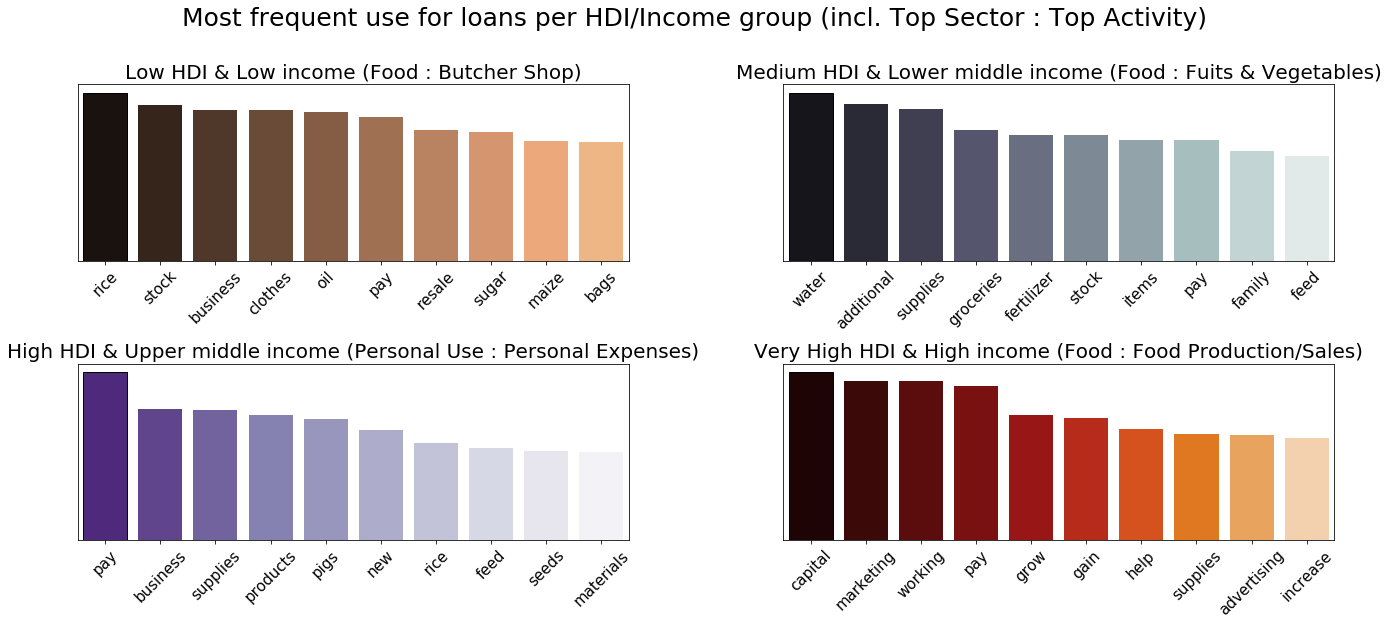

In [124]:
fig, ax = plt.subplots(2,2,figsize=(20, 8))

a = sns.barplot(w1['term'], w1['weight'], palette="copper", ax=ax[0][0], order=w1["term"].tolist(), linewidth=1, edgecolor='k')
b = sns.barplot(w2['term'], w2['weight'], palette="bone", ax=ax[0][1], order=w2["term"].tolist(), linewidth=1, edgecolor='k')
c = sns.barplot(w3['term'], w3['weight'], palette="Purples_r", ax=ax[1][0], order=w3["term"].tolist(), linewidth=1, edgecolor='k')
d = sns.barplot(w4['term'], w4['weight'], palette="gist_heat", ax=ax[1][1], order=w4["term"].tolist(), linewidth=1, edgecolor='k')

ax[0][0].set_title('Low HDI & Low income (Food : Butcher Shop)', fontsize=20)
ax[0][0].get_yaxis().set_visible(False)
ax[0][0].get_xaxis().get_label().set_visible(False)
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), fontsize=15, rotation=45)

ax[0][1].set_title('Medium HDI & Lower middle income (Food : Fuits & Vegetables)', fontsize=20)
ax[0][1].get_yaxis().set_visible(False)
ax[0][1].get_xaxis().get_label().set_visible(False)
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), fontsize=15, rotation=45)

ax[1][0].set_title('High HDI & Upper middle income (Personal Use : Personal Expenses)', fontsize=20)
ax[1][0].get_yaxis().set_visible(False)
ax[1][0].get_xaxis().get_label().set_visible(False)
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), fontsize=15, rotation=45)

ax[1][1].set_title('Very High HDI & High income (Food : Food Production/Sales)', fontsize=20)
ax[1][1].get_yaxis().set_visible(False)
ax[1][1].get_xaxis().get_label().set_visible(False)
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), fontsize=15, rotation=45)

plt.suptitle('Most frequent use for loans per HDI/Income group (incl. Top Sector : Top Activity)', fontsize=25, y=1.08)
plt.tight_layout()
plt.show()

We can clearly see that there is a distinct difference between the types of Use for loans, depending on their Economic/Development category - This is to say that someone from a Low Income & Low Development category might not take a loan for the same reasons as someone from a High Income & High Development Category


- For <b> Low Income & Low Development </b> sector, the loans are motivated by basic items of survival, such as <b> Food (rice, oil, sugar, maize), clothes </b>
- For <b> Very High Income & High Development </b>, the loans are being used for <b> capital, marketing, advertising, pay, grow </b> - which could indicate uses motivated by economies that have <b> high business opportunities, innovation </b>
- <b> Moderately Developed </b> sectors have a mix of uses, going from <b> basic needs (water, supplies, groceries, stock, family) </b> in the <b> Medium/Lower Middle bracket to more <b> business related items (business, supplies, products) </b> in the <b> High/Upper middle bracket </b>

## Analysis of Poverty Levels

Next we will take a look at world-wide poverty levels, try to understand which factors/measures collectively affect Poverty at national or regional levels & then try to build a model to determine the Poverty level, with given values for certain measures for that region


Let's read in some more metrics to understand which factors affect poverty

We will consider the following datasets for this analysis, to determine poverty levels: <br>
- <b>Sector-wise growth </b> - Growth in the sectors of Agriculture, Industry, Services & Manufacturing - to see if growth in these aspects could affect overall growth of an economy

- <b>Literacy Rates </b> - for both Male & Female

- <b>GINI Index </b> - measures the inequality in income or wealth distribution of a nation's residents

- Amount of loans given by <b>International Bank for Reconstruction and Development (World Bank) </b> to countries in need - To see if the maximum number of International Loans goes out to countries with the maximum Poverty levels

- <b>Inflation </b> - Inflation rates in COuntries over the years, to see if a high rate of Inflation is connected with higher Poverty Levels

- <b>Population & Population Density </b>


In [160]:
# Source: World Bank datasets
# International Bank for Reconstruction and Development Loans to countries in need
ibrd = pd.read_csv('data/Self data/IBRD_Loans.csv', 'Data', index_col=None, engine='python', delimiter=",")

# Inflation
infl = pd.read_excel('data/Self data/Inflation.xls', 'Data', index_col=None)

# GINI Index (Inequality)
gini = pd.read_excel('data/Self data/GINI Index.xls', 'Data', index_col=None)

# Growth in sectors
sectors = pd.read_excel('data/Self data/By_Sector.xlsx', 'Data', index_col=None)

# Literacy Rate Female
lit_f = pd.read_excel('data/Self data/Literacy_Rate_F.xls', 'Data', index_col=None)

# Literacy Rate Male
lit_m = pd.read_excel('data/Self data/Literacy_Rate_M.xls', 'Data', index_col=None)

# Population Density
popu_den = pd.read_excel('data/Self data/Population Density.xls', 'Data', index_col=None)

Next, we will take into account MPI data from OPHI, for different countries & regions:


<b>MPI (Multidimensional Poverty Index) </b>
<br>
The global Multidimensional Poverty Index (MPI) is an international measure of acute poverty covering over 100 developing countries. It complements traditional income-based poverty measures by capturing the severe deprivations that each person faces at the same time with respect to education, health and living standards.
<br>
The Multidimensional Poverty Index (MPI) identifies multiple deprivations at the household and individual level in health, education and standard of living. 
The MPI assesses poverty at the individual level. If someone is deprived in a third or more of ten (weighted) indicators (see left), the global index identifies them as ‘MPI poor’, and the extent – or intensity – of their poverty is measured by the number of deprivations they are experiencing.


We will consider the following factors related to MPI: <br>
- <b> MPI_Country </b> - MPI of the Country
- <b> MPI_Region </b> - MPI of the Region
- <b> Population_in_Med_MPI_p </b> - Percentage of Population in Medium MPI (Vulnerable to poverty (who experience 20-33.32% intensity of deprivations) )
- <b> Population_in_High_MPI_p </b> - Percentage of Population in High MPI (In severe poverty (with intensity higher than 50%) )
- <b> Destitutes_p </b> - without the basic necessities of life
- <b> Inequality </b> - Inequality among the poor

In [130]:
# MPI of countries
mpi_c = pd.read_excel('data/Self data/MPI_National.xlsx', 'Data', index_col=None)

#MPI of Regions
mpi_r = pd.read_excel('data/Self data/MPI_Regional.xlsx', 'Data', index_col=None)

mpi1 = mpi_r[['Country', 'Region','MPI_Region']].merge(mpi_c, how="right", on = "Country")
mpi1 = mpi1[['Country_Code', 'World_Region', 'Country', 'Region', 'MPI_Country', 'MPI_Region', 'Population_in_Med_MPI_p', 'Population_in_High_MPI_p', 'Destitutes_p', 'Inequality', 'Population']]
mpi1['MPI_Region'] = mpi1['MPI_Region'].fillna(0)

In [161]:
# Merge MPI with GDP & HDI
mpi2 = mpi1.merge(countries[['Country']], how="outer", on = "Country")
mpi2 = mpi2.merge(gdp, how="left", on = "Country")
mpi2 = mpi2.merge(hdi, how="left", on = "Country")
mpi2.loc[(mpi2.HDI_Scale=='Very High') & (mpi2['MPI_Country'].isnull()), 'MPI_Country'] = 0
mpi2.loc[(mpi2.HDI_Scale=='Very High') & (mpi2['MPI_Country'].isnull()), 'MPI_Region'] = 0
mpi2.loc[(mpi2.HDI_Scale=='High') & (mpi2['MPI_Country'].isnull()), 'MPI_Country'] = 0.001
mpi2.loc[(mpi2.HDI_Scale=='High') & (mpi2['MPI_Country'].isnull()), 'MPI_Region'] = 0.001

# Merge with other metrics
mpi3 = mpi2.copy()
mpi3 = mpi3.merge(lend, how="left", on = "Country")
mpi3 = mpi3.merge(pgdp, how="left", on = "Country")
mpi3 = mpi3.merge(ibrd, how="left", on = "Country")
mpi3 = mpi3.merge(infl, how="left", on = "Country")
mpi3 = mpi3.merge(gini, how="left", on = "Country")
mpi3 = mpi3.merge(sectors, how="left", on = "Country")
mpi3 = mpi3.merge(lit_f, how="left", on = "Country")
mpi3 = mpi3.merge(lit_m, how="left", on = "Country")
mpi3 = mpi3.merge(popu_den, how="left", on = "Country")
mpi3 = mpi3.merge(inc, how="left", on = "Country")

bins = [0,0.05,0.35,0.7]
group_names = ['Low','Medium','High']
mpi3["MPI_Category"] = pd.cut(mpi3["MPI_Country"], bins, labels=group_names)

mpi3["Sector_total"] = mpi3["Industry"] + mpi3["Manu"] + mpi3["Services"] - mpi3["Agri"]
mpi3["Literacy"] = (mpi3["Lit_Rate_F"] + mpi3["Lit_Rate_M"])/2

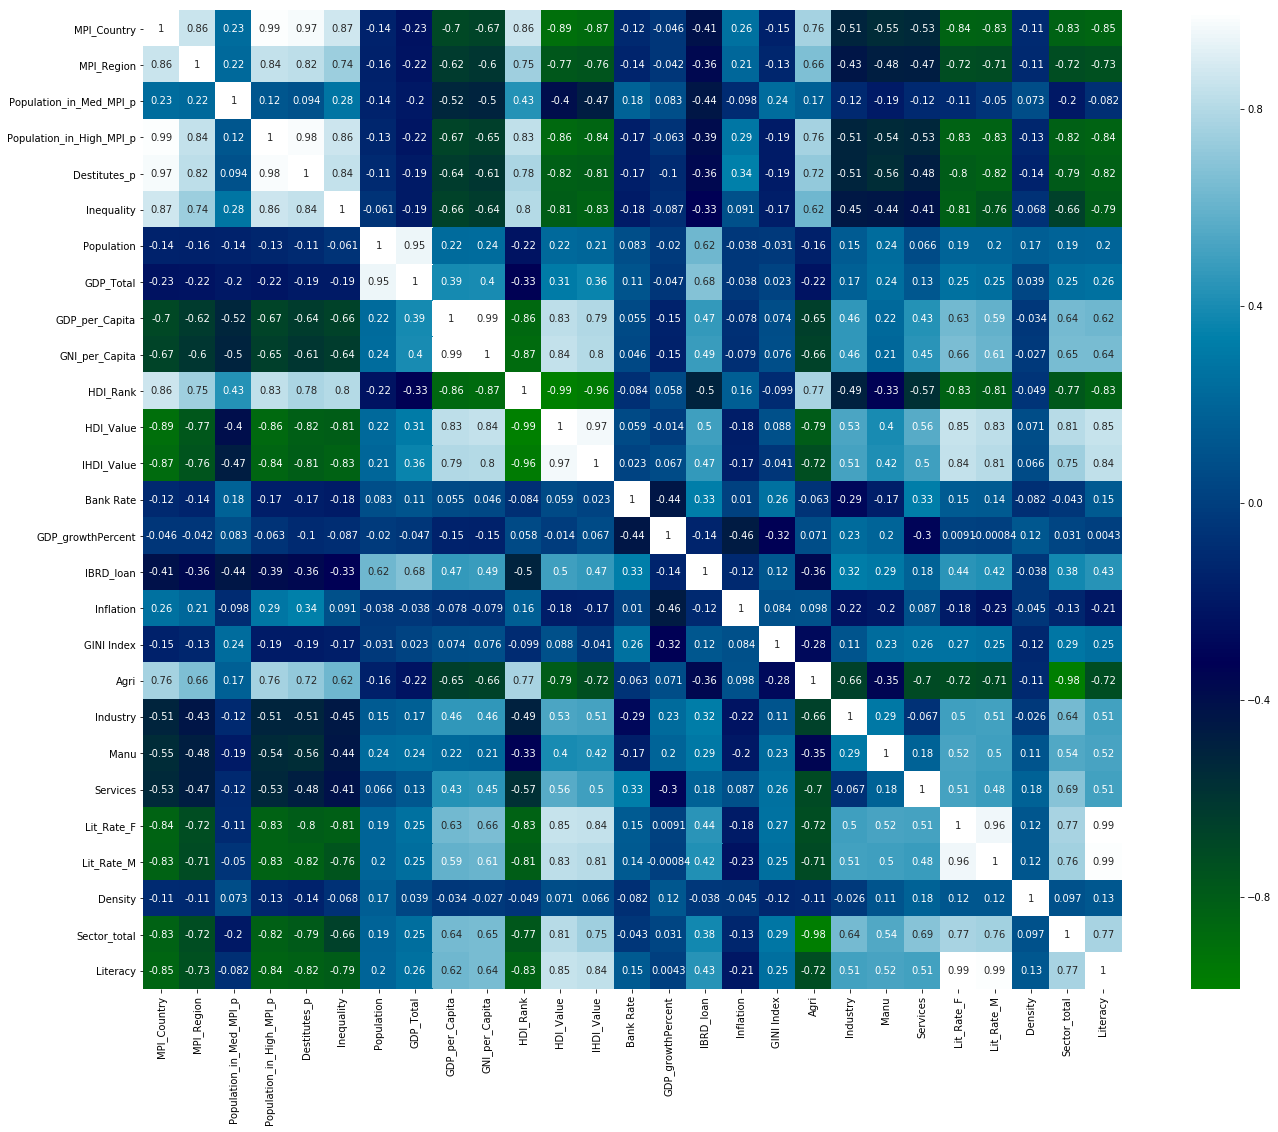

In [162]:
fig, ax = plt.subplots(figsize=(25,18))
c = mpi3.corr()
sns.heatmap(c, annot=True, ax=ax, square=True, cmap="ocean")
plt.show()

#### Highly positively correlated factors
- <b> Population in MPI </b>: Higher percentage of people in Higher Poverty (in terms of Intensity of MPI) results in a Higher MPI score, than   Higher percentage of people in Moderate Intensity MPI 
- <b> Destitutes </b>: Higher ratio of destitutes indicates higher levels of Poverty
- <b> Inequality </b>: Higher inequality in poverty-ridden population indicates higher overall poverty levels
- <b> HDI Rank </b>: Higher HDI Rank (indicating lower HDI/IHDI Scores - lower Human Development) indicates higher Poverty levels
- <b> Agriculture </b>: Higher values indicate Higher Poverty


#### Highly inversely correlated factors
- <b> GDP per Capita, GNI per Capita </b>: Higher levels of per Capita Income or Domestic Product indicate lower levels of Poverty
- <b> HDI Value, IHDI Value </b>: Higher Levels or (Inequality adjusted) Human Development indicates lower Poverty Levels
- <b> Industry, Services & Manufacturing </b>: Higher values indicate lower Poverty levels
- <b> Literacy Rate(Male & Female) </b>: Higher values indicate lower Poverty levels


#### Moderately correlated factors
- International Bank for Reconstruction and Development Loan Amount


#### Lowly correlated factors
- Population , population density 
- Local banks lending interest rates 
- Percentage of GDP Growth 
- Inflation
- GINI Index

#### Define Poverty Score Targeting Groups based on relevant factors

<b> Poverty Score Targeting Groups: </b>
- <b> P1 </b> -  Low Human Development, Low Income Category, High MPI Poverty Level
- <b> P2 </b> -  Low Human Development, Lower middle Income Category, High MPI Poverty Level
- <b> P3 </b> -  Low Human Development, Low Income Category, Medium MPI Poverty Level
- <b> P4 </b> -  Low Human Development, Lower middle Income Category, Medium MPI Poverty Level
- <b> P5 </b> -  Low Human Development, Low Income Category, Low MPI Poverty Level
- <b> P6 </b> -  Low Human Development, Lower middle Income Category, Low MPI Poverty Level
- <b> P7 </b> -  Medium Human Development, Low Income Category, Medium MPI Poverty Level
- <b> P8 </b> -  Medium Human Development, Upper middle Income Category, Medium MPI Poverty Level
- <b> P9 </b> -  Medium Human Development, Lower middle Income Category, Medium MPI Poverty Level
- <b> P10 </b> - Medium Human Development, Low Income Category, Low MPI Poverty Level
- <b> P11 </b> - Medium Human Development, Upper middle Income Category, Low MPI Poverty Level
- <b> P12 </b> - Medium Human Development, Lower middle Income Category, Low MPI Poverty Level
- <b> P13 </b> - High Human Development, Lower middle Income Category, Low MPI Poverty Level
- <b> P14 </b> - High Human Development, Upper middle Income Category, Low MPI Poverty Level
- <b> P15 </b> - Very High Human Development, High Income Category, Low MPI Poverty Level

In [133]:
#mpi3.loc[((mpi3.HDI_Scale == "Very High") & (mpi3.IncomeCategory == "High income") & (mpi3.MPI_Category == "Low")), 'Score'] = 'P15'
mpi3.loc[((mpi3.HDI_Scale == "High") & (mpi3.IncomeCategory == "Upper middle income") & (mpi3.MPI_Category == "Low")), 'Score'] = 'P14'
mpi3.loc[((mpi3.HDI_Scale == "High") & (mpi3.IncomeCategory == "Lower middle income") & (mpi3.MPI_Category == "Low")), 'Score'] = 'P13'
mpi3.loc[((mpi3.HDI_Scale == "Medium") & (mpi3.IncomeCategory == "Lower middle income") & (mpi3.MPI_Category == "Low")), 'Score'] = 'P12'
#mpi3.loc[((mpi3.HDI_Scale == "Medium") & (mpi3.IncomeCategory == "Upper middle income") & (mpi3.MPI_Category == "Low")), 'Score'] = 'P11'
#mpi3.loc[((mpi3.HDI_Scale == "Medium") & (mpi3.IncomeCategory == "Low income") & (mpi3.MPI_Category == "Low")), 'Score'] = 'P10'
mpi3.loc[((mpi3.HDI_Scale == "Medium") & (mpi3.IncomeCategory == "Lower middle income") & (mpi3.MPI_Category == "Medium")), 'Score'] = 'P9'
mpi3.loc[((mpi3.HDI_Scale == "Medium") & (mpi3.IncomeCategory == "Upper middle income") & (mpi3.MPI_Category == "Medium")), 'Score'] = 'P8'
mpi3.loc[((mpi3.HDI_Scale == "Medium") & (mpi3.IncomeCategory == "Low income") & (mpi3.MPI_Category == "Medium")), 'Score'] = 'P7'
#mpi3.loc[((mpi3.HDI_Scale == "Low") & (mpi3.IncomeCategory == "Lower middle income") & (mpi3.MPI_Category == "Low")), 'Score'] = 'P6'
#mpi3.loc[((mpi3.HDI_Scale == "Low") & (mpi3.IncomeCategory == "Low income") & (mpi3.MPI_Category == "Low")), 'Score'] = 'P5'
mpi3.loc[((mpi3.HDI_Scale == "Low") & (mpi3.IncomeCategory == "Lower middle income") & (mpi3.MPI_Category == "Medium")), 'Score'] = 'P4'
mpi3.loc[((mpi3.HDI_Scale == "Low") & (mpi3.IncomeCategory == "Low income") & (mpi3.MPI_Category == "Medium")), 'Score'] = 'P3'
#mpi3.loc[((mpi3.HDI_Scale == "Low") & (mpi3.IncomeCategory == "Lower middle income") & (mpi3.MPI_Category == "High")), 'Score'] = 'P2'
mpi3.loc[((mpi3.HDI_Scale == "Low") & (mpi3.IncomeCategory == "Low income") & (mpi3.MPI_Category == "High")), 'Score'] = 'P1'

To note here, there are no data for the following groups:
<br>
- P2 -  Low Human Development, Lower middle Income Category, High MPI Poverty Level
- P5 -  Low Human Development, Low Income Category, Low MPI Poverty Level
- P6 -  Low Human Development, Lower middle Income Category, Low MPI Poverty Level
- P10 - Medium Human Development, Low Income Category, Low MPI Poverty Level
- P11 - Medium Human Development, Upper middle Income Category, Low MPI Poverty Level
- P15 - Very High Human Development, High Income Category, Low MPI Poverty Level



#### Predicting Poverty Score Targeting Group

Poverty Score Group prediction will be done based on the following factors:
- GDP per Capita
- GNI per Capita
- HDI Value
- IHDI Value
- GINI Index
- IBRD loan amount
- Literacy (Combined Male,Female)
- Sector total (Combined total of Agriculture, Industry, Manufacturing & Services)
- MPI measures (MPI_Country, MPI_Region, Population_in_High_MPI_p, Destitutes_p, Inequality)


In [134]:
mpi4=mpi3[['GDP_per_Capita', 'GNI_per_Capita',
           'HDI_Value', 'IHDI_Value',
           'GINI Index', 'IBRD_loan', 
           'Literacy', 'Sector_total', 
           'MPI_Country','MPI_Region', 'Population_in_High_MPI_p', 'Destitutes_p', 'Inequality',
           'Score']]
# 'GDP_per_Capita', 'GNI_per_Capita', 'HDI_Rank', 'HDI_Value', 'IHDI_Value'
# 'Amount_bl', 'GINI Index', 
# 'Agri', 'Industry', 'Manu', 'Services', 'Sector_total', 
# 'Lit_Rate_F', 'Lit_Rate_M', 'Literacy', 
# 'MPI_Country','MPI_Region', 'Population_in_High_MPI_p', 'Destitutes_p', 'Inequality', 

mpi4=mpi4.dropna().reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



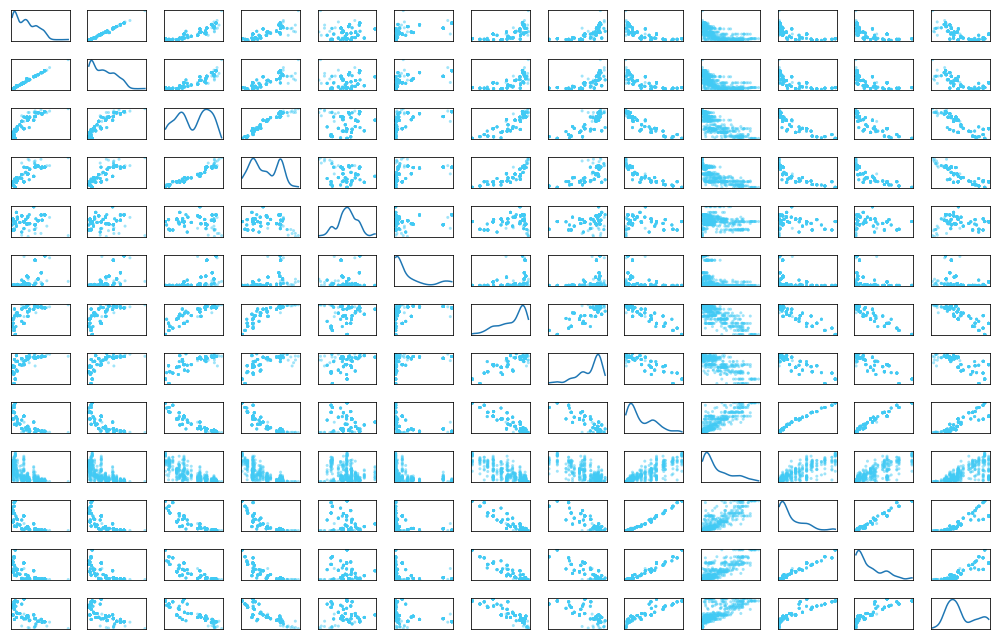

In [151]:
fig,ax=plt.subplots(figsize=(14,9))

sm = pd.plotting.scatter_matrix(mpi4, diagonal="kde", c='#41caf4',ax=ax)
for subaxis in sm:
        for ax in subaxis:
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])            
            ax.set_ylabel("")
            ax.set_xlabel("")

plt.tight_layout()
plt.show()

In [76]:
X = mpi4.loc[:, mpi4.columns != 'Score']
y=mpi4.Score

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

In [77]:
knn = KNeighborsClassifier(n_neighbors =1)
model_k = knn.fit(Xtrain, ytrain)
preds_k = model_k.predict(Xtest)

print(classification_report(ytest, preds_k))

             precision    recall  f1-score   support

         P1       1.00      1.00      1.00        16
        P12       1.00      1.00      1.00         7
        P13       1.00      0.50      0.67         2
        P14       0.94      1.00      0.97        15
         P3       1.00      1.00      1.00        13
         P4       1.00      1.00      1.00        16
         P7       1.00      1.00      1.00         2
         P8       1.00      1.00      1.00         1
         P9       1.00      1.00      1.00        39

avg / total       0.99      0.99      0.99       111



In [78]:
Xtest.to_csv('predictions.csv')
p=pd.read_csv('predictions.csv')
p['Results'] = preds_k
p.to_csv('predictions.csv')

## Data Analysis of Top 20 Regions

In [81]:
# We will keep the above dataset for future reference & create another one for current (Country-wise) analysis
kiva_reg = kiva_full.copy()
kiva_reg = kiva_reg.drop(labels=['id', 'use', 'tags', 'country_code', 'currency', 'partner_id', 'disbursed_time', 'funded_time', 'posted_time', 'borrower_genders', 'funded_amount'], axis=1)
kiva_reg = kiva_reg.dropna(subset = ['region'], axis=0)

# Region
for i, row in kiva_reg.iterrows():
    g = list()
    val = row.loc['region']
    g.extend(l.strip() for l in val.split(","))
    
    if (len(g) > 2):
        reg = g[-1:]
    else:
        reg = g
    
    reg = ' '.join(str(r) for r in reg)    
    
    kiva_reg.set_value(i, 'reg', reg)    
    
kiva_reg.columns = ['Amount', 'Activity', 'Sector', 'Country', 'SubRegion', 'Term', 'Lenders', 'Repayment_Interval', 'Date', 'Females', 'Males', 'Log_Amount', 'Region']
kiva_reg = kiva_reg [['Country', 'Region', 'Sector', 'Activity', 'Date', 'Repayment_Interval', 'Term', 'Amount', 'Log_Amount', 'Lenders', 'Females', 'Males', 'SubRegion']]

# We will make a copy of the dataset for the current analysis
df_reg_all = kiva_reg.groupby(['Country','Region']).size().reset_index(name="NumberOfLoans").sort_values('NumberOfLoans', ascending=False).reset_index(drop=True)

In [82]:
# List of top 20 regions & their geographic coordinates
top20_reg_geo = df_reg_all[:20].copy()

for i, row in top20_reg_geo.iterrows():
    try:
        geolocator = Nominatim()
        location = geolocator.geocode(row.Region)
        lat = location.latitude
        lon = location.longitude
        top20_reg_geo.set_value(i, 'r_lat', lat)
        top20_reg_geo.set_value(i, 'r_lon', lon)
    except AttributeError:
        pass

# Save to file so that geocode function doesnt have to be re run
top20_reg_geo.to_csv("Top20_Regions_geo.csv", index=False)   

In [83]:
top20_reg_data = pd.read_csv("Top20_Regions_geo.csv", engine="python")

#top20_reg_data = top20_reg_geo.copy()
top20_reg_data = top20_reg_data.merge(kiva_reg.groupby(['Region'],as_index=False).Amount.sum())
top20_reg_data = top20_reg_data.merge(kiva_reg.groupby(['Region'],as_index=False).Lenders.sum())
top20_reg_data = top20_reg_data.merge(kiva_reg.groupby(['Region'],as_index=False).Females.sum())
top20_reg_data = top20_reg_data.merge(kiva_reg.groupby(['Region'],as_index=False).Males.sum())
top20_reg_data = top20_reg_data.merge(kiva_reg.groupby('Region',as_index=False).Sector.first())
top20_reg_data = top20_reg_data.merge(kiva_reg.groupby('Region',as_index=False).Activity.first())
top20_reg_data = top20_reg_data.merge(kiva_reg.groupby('Region',as_index=False).Repayment_Interval.first())
top20_reg_data = top20_reg_data.merge(kiva_reg.groupby('Region',as_index=False).Term.first())

- Interestingly, if we look at the Regions with the maximum number of loans - they are quite different from the Top Countries list
- Even though Philippines was the country with the maximum number of loans, region-wise the maximum number of loans is taken by Kaduna, Nigeria
- On further analysis, we see that there are 21 regions in Nigeria that takes Kiva loans, whereas in Philippines there are 1685 such Regions
- So, the Number of Loans for Philippines increases due to the huge number of regions where Kiva is accessed
- Whereas, inspite of Kaduna region in Nigeria is the top in number of loans, other regions in Nigeria do not have an similar contribution - thereby bringing Nigeria to the 15th place in the list of Top Countries in terms of number of loans

In [84]:
m1 = folium.Map(location=[0,0], tiles="Stamen Toner",  zoom_start=2)

for i in range(0,len(top20_reg_data)):
    sr1 = round(top20_reg_data.iloc[i]["Males"]/top20_reg_data.iloc[i]["Females"], 2)
    popup_text1 = "Country: {}<br> Region: {}<br> Rank: {}<br> Loans: {}<br> Sector: {}<br> Sex Ratio: {}<br> Total Loan: {}<br> Repayment Interval: {}"
    popup_text1 = popup_text1.format(top20_reg_data.iloc[i]["Country"],
                                   top20_reg_data.iloc[i]["Region"],
                                   i+1,
                                   top20_reg_data.iloc[i]["NumberOfLoans"],
                                   top20_reg_data.iloc[i]["Sector"],
                                   sr1,
                                  top20_reg_data.iloc[i]['Amount'],
                                  top20_reg_data.iloc[i]['Repayment_Interval'])
    
    
    folium.Marker([top20_reg_data.iloc[i]['r_lat'],
                   top20_reg_data.iloc[i]['r_lon']],
                  popup=popup_text1,
                 icon = folium.Icon(color='purple', icon='address-card')).add_to(m1)
    
display(m1)

### The pop ups displayed on clicking the markers in the above map, provides a comprehensive view of the Top 20 Regions:
- Country Name
- Region Name
- Rank in terms of Number of Loans
- Number of Loans
- Top Sector
- Sex Ratio
- Total Loan Amount
- Most popular Repayment Interval

# Inferences, in conclusion

### Generic Analysis
</b>
- The <b> Top 20 countries </b> in terms of Number of Loans are: <br>
    'Philippines', 'Kenya', 'El Salvador', 'Cambodia', 'Pakistan', 
    'Peru', 'Colombia', 'Uganda', 'Tajikistan', 'Ecuador', 'Paraguay', <br>
    'Nicaragua', 'India', 'Vietnam', 'Nigeria', 'Bolivia', 'Lebanon', 
    'Armenia', 'Palestine', 'Samoa'
      
      
- The Top countries in terms of <b> maximum Number of Loans per Region </b> are:  <br>
    'Nigeria', 'Pakistan', 'Peru', 'Tanzania', 'Kenya', 'Philippines', 
    'Vietnam', 'Colombia', 'Ecuador', 'El Salvador' <br>
       
       
- The <b> Top 20 Regions </b> in terms Number of Loans are: <br>
    'Kaduna', 'Lahore', 'Rawalpindi', 'Cusco', 'Dar es Salaam', 
    'Kisii', 'Palo Leyte', 'Narra Palawan', 'Misamis Occidental', <br>
    'Quezon Palawan', 'Kitale', 'Thanh Hoá', 'Medellín', 'Isabela', 
    'Tacloban City Leyte', 'Brookes Point Palawan', <br>
    'Kabankalan Negros Occidental', 'San Gabriel', 'Eldoret', 
    'San Miguel'
       
       
- The <b> Top Sectors </b> are: <br>
    Agriculture, Food, Retail, Services, Personal Use


- The <b> Top Activities </b> are: <br>
    Farming, General Store, Personal Housing Expenses, Food Production/Sales, Agriculture
       
       
- <b> Top activities per Sector </b> are:
    - Sector - "Agriculture" ::: Activities - "Agriculture", "Farming", "Pigs"
    - Sector - "Food" ::: Activities - "Food Production/Sales", "Fruits & Vegetables", "Grocery Store"
    - Sector - "Personal Use" ::: Activities - "Home Appliances", "Energy", "Personal Expenses"
    - Sector - "Retail" ::: Activities - "Cosmetic Sales", "General Store", "Retail"
    - Sector - "Services" ::: Activities - "Services", "Sewing", "Tailoring"



### Time based Analysis

- Out of all Kiva countries,
    - for 46 countries <b> (54% of countries) Number of Loans has increased </b> from 2014 to 2016
    - for 38 countries <b> (46% of countries) Number of Loans has decreased </b> from 2014 to 2016

- There has been increase in all the Repayment Intervals over time, except for Weekly
    - Popularity for <b> Bullet </b> intervals has <b> increased by 27% </b> between 2014 to 2016
    - Popularity for <b> Irregular </b> intervals has <b> increased by 9.7% </b> between 2014 & 2016
    - Popularity for <b> Monthly </b> intervals has <b> increased by 13.5% </b> between 2014 & 2016
    - So, <b> Bullet seems to be the interval growing </b> most in popularity  over the years & Weekly is the interval decreasing most in             popularity over time


- There is a high correlation between Funded Amount & Loan Amount
    - For the majority, <b> Funded Amount = Loan Amount </b>
    - There are few instances for which, Funded Amount < Loan Amount
    - However, we do not see any instances for which, Funded Amount > Loan Amount
    - As conclusion we could say that <b> the amount that gets actually funded (amount funded from lenders) is equal to or less than the loan           amount (amount requested by the borrower) </b> for each loan

### Income/Development classification related Analysis:

- A total of <b>  329699 </b> Kiva borrowers are from the <b> Medium HDI & Lower Middle Income brackets </b>
- So, this bracket accounts for almost <b> 64 % Kiva borrowers </b>
- <b> 72%  </b> of Kiva borrowers are from the countries that have a <b> High GDP Growth </b>
<br>
- <b> 41%  </b> of Kiva borrowers are from the countries that have a <b> High Bank Lending Rate </b>
<br>
- <b> 56%  </b> of Kiva borrowers are from the countries that are from the <b> Medium HDI , Lower Middle Income & High GDP Growth brackets </b>


There is a distinct difference between the types of Use for loans, depending on their Economic/Development category - This is to say that someone from a Low Income & Low Development category might not take a loan for the same reasons as someone from a High Income & High Development Category


- For <b> Low Income & Low Development </b> sector, the loans are motivated by basic items of survival, such as <b> Food (rice, oil, sugar, maize), clothes </b>
- For <b> Very High Income & High Development </b>, the loans are being used for <b> capital, marketing, advertising, pay, grow </b> - which could indicate uses motivated by economies that have <b> high business opportunities, innovation </b>
- <b> Moderately Developed </b> sectors have a mix of uses, going from <b> basic needs (water, supplies, groceries, stock, family) </b> in the <b> Medium/Lower Middle bracket to more <b> business related items (business, supplies, products) </b> in the <b> High/Upper middle bracket </b>




### Poverty Levels Related Analysis

#### Highly positively correlated factors
- <b> Population in MPI </b>: Higher percentage of people in Higher Poverty (in terms of Intensity of MPI) results in a Higher MPI score, than Higher percentage of people in Moderate Intensity MPI 
- <b> Destitutes </b>: Higher ratio of destitutes indicates higher levels of Poverty
- <b> Inequality </b>: Higher inequality in poverty-ridden population indicates higher overall poverty levels
- <b> HDI Rank </b>: Higher HDI Rank (indicating lower HDI/IHDI Scores - lower Human Development) indicates higher Poverty levels
- <b> Agriculture </b>: Higher values indicate Higher Poverty


#### Highly inversely correlated factors
- <b> GDP per Capita, GNI per Capita </b>: Higher levels of per Capita Income or Domestic Product indicate lower levels of Poverty
- <b> HDI Value, IHDI Value </b>: Higher Levels or (Inequality adjusted) Human Development indicates lower Poverty Levels
- <b> Industry, Services & Manufacturing </b>: Higher values indicate lower Poverty levels
- <b> Literacy Rate(Male & Female) </b>: Higher values indicate lower Poverty levels



### References/Citations:

- http://cadmusjournal.org/node/11
- https://data.worldbank.org/indicator
- http://hdr.undp.org/
- https://www.kiva.org/about/
- Data Tables 1.1 – 7 as: Alkire, S. and Robles, G. (2017). “Multidimensional Poverty Index Summer 2017: Brief methodological note and results.” OPHI Methodological Note 44, University of Oxford.